## Analysis of results from a panel of deconvolution methods

We load here all tables obtained in notebook Fig3_XX, which represents the tables of predicted cell subtype abundance obtained by our panel of deconvolution methods. We also load true proportions contained in the same folder, allowing to compute 4 metrics: the Pearson correlation coeficient (PCC), the Spearman correlation coefficient (SCC), the root mean square error (RMSE), and the R-square (R2). We use a per-bulk comparison: for each bulk, we compare the predicted versus the true cell subtype abundance. We thus obtain N accuracy value, for all N bulks in a given experiment.

We show here the results for 12 different analysis decribed below, with the corresponding cancer type: 

- Mixed Leukemic cell lines (AML): The in-vitro experiment performed in our laboratory, where true cell line proportions were recorded after cell counting. Cell mix were directly sequenced without co-culturing cells. We thus have cell counts for each line as a ground truth, and the results of deconvolution methods obtained through an actual bulk RNA-seq.
- Van Galen > Naldini (AML): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Van Galen was used as a reference to deconvolute the pseudo-bulks made from Naldini dataset, after data integration and transfering of cell subtype labels from Van Galen to Naldini. 
- Naldini > Van Galen (AML): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Naldini was used as a reference to deconvolute the pseudo-bulks made from Van Galen dataset, after data integration and transfering of cell subtype labels from Naldini to Van Galen. 
- 200 simulated bulks (AML): Simulated dataset of 200 bulks made from Van Galen scRNA-seq dataset. 
- Lee > Khaliq (CRC): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Lee was used as a reference to deconvolute the pseudo-bulks made from Khaliq dataset, after data integration and transfering of cell subtype labels from Lee to Khaliq. 
- Khaliq > Lee (CRC): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Khaliq was used as a reference to deconvolute the pseudo-bulks made from Lee dataset, after data integration and transfering of cell subtype labels from Lee to Khaliq (labels from Lee were used here as we did not find good labels for Khaliq dataset).
- Jerby > Tirosh (Melanoma): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Jerby was used as a reference to deconvolute the pseudo-bulks made from Tirosh dataset, after data integration and transfering of cell subtype labels from Jerby to Tirosh. 
- Tirosh > Jerby (Melanoma): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Tirosh was used as a reference to deconvolute the pseudo-bulks made from Jerby dataset, after data integration and transfering of cell subtype labels from Tirosh to Jerby.
- Wu > Gray (Breast cancer): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Wu was used as a reference to deconvolute the pseudo-bulks made from Gray dataset, after data integration and transfering of cell subtype labels from Wu to Gray. 
- Gray > Wu (Breast cancer): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Gray was used as a reference to deconvolute the pseudo-bulks made from Wu dataset, after data integration and transfering of cell subtype labels from Gray to Wu.
- Neftel (10X) > Neftel (SmartSeq2) (GBM): Cross-technology pseudo-bulk analysis where the scRNA-seq dataset from 10X was used as a reference to deconvolute the pseudo-bulks made from SmartSeq2 dataset, after data integration and transfering of cell subtype labels from 10X to SmartSeq2.
- Neftel (SmartSeq2) > Neftel (10X) (GBM): Cross-technology pseudo-bulk analysis where the scRNA-seq dataset from SmartSeq2 was used as a reference to deconvolute the pseudo-bulks made from 10X dataset, after data integration. Only the 10X dataset had available cell subtype labels, they were thus used on the SmartSeq2 data.

In [6]:
library(ggplot2) ; library(glmnet) ; library(Biobase)
library(reshape2) ; library(ggpubr); library(BayesPrism)
library(MuSiC) ; library(SingleCellExperiment) ; library(BisqueRNA)
library(climb) ; library(ComplexHeatmap) ; library(circlize) ; library(RColorBrewer)
library(cocor) ; library(ggpmisc) # important library to compare correlations

In [3]:
#detach("package:climb", unload=TRUE)
#devtools::install_github('alexdray86/climb', force=T)
#library(climb)

### Functions 

In [7]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){
    return( sign(cor(pr,tr))*cor(pr,tr)^2 )
}
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
} 

### Function for each deconvolution methods ### 
deconvolution_climb <- function(sc, bulks, true_prop, celltype_names){
    climb_res = climb(sc, bulks, dwls_weights = F, mode='abundance')
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_climb_dw <- function(sc, bulks, true_prop, celltype_names){
    climb_res = climb(sc, bulks, dwls_weights = T, mode='abundance')
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}                                                                                         
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
launch_climb_deconvolution <- function(sc, bulks, true_prop, celltype_names, out_dir){
    # Create folders
    message('Creating folders')
    tmp_dir = paste0(out_dir, '/tmp_tabs')
    dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)
    
    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, true_prop, celltype_names)
    write.csv(climb_prop, paste0(out_dir, '/climb_prop.csv'), quote=F)
    message(paste0('CLIMB Accruacy as PCC: ', cor(flatten(true_prop), flatten(climb_prop))))
    
    ### CLIMB deconvolution ###
    message('CLIMB-DW deconvolution')
    climb_dw_prop = deconvolution_climb_dw(sc, bulks, true_prop, celltype_names)
    write.csv(climb_dw_prop, paste0(out_dir, '/climb_dw_prop.csv'), quote=F)
    message(paste0('CLIMB Accruacy as PCC: ', cor(flatten(true_prop), flatten(climb_dw_prop))))
}

load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')[,celltype_names]
    #climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')[,celltype_names]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,celltype_names]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,celltype_names]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,celltype_names]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,celltype_names]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,celltype_names]
    tape_p = load_tape_prop(tdir, odir, celltype_names)
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)
    if(include_cibersortx){
        csx_p = add_missing_celltypes(read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='Mixture'), celltype_names)[,celltype_names]
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_p) ; true_prop_rows = rownames(true_p)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}  

gene_intersection <- function(dataset1, dataset2){
    message('Finding gene intersect between two datasets')
    gene_intersect = intersect(rownames(dataset1), rownames(dataset2))
    message(paste0(length(gene_intersect), ' genes in common between two datasets. Subsetting datasets.'))
    return(gene_intersect)
}
generate_final_datasets <- function(ref_sc, target_sc, var.genes){
    # Generate pseudo-bulk from single-cell ExpressionSet object
    # Use 'SubjectName' field to create pseudo-bulk samples 
    # Use 'cellType' field to create ground truth proportions in pData
    ref_sc = ref_sc[var.genes,]
    gene_intersect <- gene_intersection(ref_sc, target_sc)
    ref_sc = ref_sc[gene_intersect,]
    target_sc = target_sc[gene_intersect,]
    
    message('Setting cell-type factors as in reference')
    #ref_sc$cellType_original = factor(ref_sc$cellType_original, leve)
    target_sc$cellType_transfered = factor(target_sc$cellType_transfered,levels = levels(ref_sc$cellType_original))
    
    message('Build pseudo-bulks and iterate over samples to compute ground truth')
    p.bulks = aggregate(t(exprs(target_sc)), list(target_sc$SubjectName), sum)
    rownames(p.bulks) = p.bulks$`Group.1`
    p.bulks = p.bulks[,-1]
    list_ct_props= list() ; list_patients = rownames(p.bulks)
    for(n in 1:length(list_patients)){
        this_patient = list_patients[n]
        sel.patient = target_sc$SubjectName == this_patient
        sc.sub = target_sc[,sel.patient]
        celltype.sub = factor(sc.sub$cellType_transfered, levels=levels(ref_sc$cellType_original))
        list_ct_props[[n]] = table(celltype.sub) / sum(table(celltype.sub))
    }
    true.prop = do.call(rbind, list_ct_props)
    true.prop = true.prop[,levels(ref_sc$cellType_original)]
    stopifnot(colnames(true.prop) == levels(ref_sc$cellType_original))
    rownames(true.prop) = list_patients
    message('Generate ExpressionSet objects containing pseudo-bulks in target dataset')
    p.bulks.es = ExpressionSet(t(p.bulks), phenoData = AnnotatedDataFrame(data.frame(true.prop)))
    return( list( ref_sc, p.bulks.es ) )
}

intra_dataset_deconvolution <- function(sc, odir){ 
    sample_names = unique(sc$SubjectName)
    sc$cellType = factor(reformat_celltypes(sc$cellType_original))
    sc$cellType_original = factor(reformat_celltypes(sc$cellType_original))
    ref_samples = sample_names[seq(1,length(sample_names),2)]
    target_samples = sample_names[seq(2,length(sample_names),2)]
    #mid_sample = round(length(sample_names) / 2)
    #ref_samples = sample_names[1:mid_sample] ; target_samples = sample_names[(mid_sample+1):length(sample_names)]
    # Make two single-cell dataset from one
    sc.es.ref = sc[,sc$SubjectName %in% ref_samples]
    sc.es.ref$cellType_original = factor(sc.es.ref$cellType, levels=levels(sc$cellType))
    sc.es.target = sc[,sc$SubjectName %in% target_samples]
    sc.es.target$cellType_transfered = factor(sc.es.target$cellType, levels=levels(sc$cellType))
    # Build reference single-cell data and pseudo-bulk
    final_data = generate_final_datasets(sc.es.ref, sc.es.target, rownames(sc.es.ref))
    sc.es = final_data[[1]]
    bulk.es = final_data[[2]]
    sc.es$cellType = factor(sc.es$cellType, levels=levels(sc$cellType))
    # define useful variables
    true_prop = pData(bulk.es)
    celltype_names = levels(sc.es$cellType)
    stopifnot(all(colnames(true_prop) == celltype_names))
    # Launch panel of deconvolution methods
    #launch_all_deconvolution_methods(sc = sc.es, bulks = bulk.es, true_prop = true_prop,
    #                                 celltype_names = celltype_names, out_dir=odir)
    return(list(sc.es, bulk.es))
}

# Change the Metric by setting type.err to 1, 2, 3, or 4
generate_comp_plot <- function(obj.res, type.err=1){
    #type.err , 1=pcor, 2=scor, 3=r_square, 4=rmse
    type.err.l = list('PCC', 'SCC', 'R2', 'RMSE')
    methods = c('MuSiC', 'NNLS', 'CLIMB', 'TAPE', 'Scaden', 'Bisque', 'Random', 'BayesPrism', 'CiberSortX')
    df_scor = data.frame(cbind(obj.res$MuSiC[[type.err]], obj.res$NNLS[[type.err]], 
                               obj.res$CLIMB[[type.err]], obj.res$TAPE[[type.err]], obj.res$Scaden[[type.err]],
                               obj.res$BisqueRNA[[type.err]], obj.res$Random[[type.err]], obj.res$BayesPrism[[type.err]], 
                               obj.res$CiberSortX[[type.err]]))
    colnames(df_scor) = methods
    levels_ = colnames(df_scor)[rev(order(colMedians(as.matrix(df_scor), na.rm = T)))]
    if(grepl('RMSE', type.err)){levels_ = rev(levels_)}
    df_scor_m = data.frame(reshape2::melt(df_scor))
    df_scor_m$variable = factor(df_scor_m$variable, levels = levels_) 
    g_rows = ggplot(data=df_scor_m, aes(x=variable, y=value, color=variable)) + 
                geom_boxplot(outlier.shape = NA) + 
                #geom_point(aes(x=variable, y=value, color=variable), position_jitter(w=0, h = 0)) + 
                geom_jitter(width=0.3, height=0.0) +
                theme_classic() +
                scale_color_manual(values=ifelse(grepl('CLIMB', levels_), 'darkred', 'grey38')) + 
                theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
                xlab('') + ylab(gsub('_per.*','',type.err)) #+ coord_flip() # ylab(expression(pa
    return(g_rows)
}

make_all_metrics <- function(all_ps, t_prop_f){
    t_prop_fd = 
    t_prop = as.matrix(read.csv(t_prop_f, row.names = 'X'))
    all_rs = list()
    for(p in 1:length(all_ps)){
        name_p = names(all_ps)[p]
        all_rs[[name_p]] = suppressWarnings(comp_rows_and_cols(all_ps[[p]], t_prop))
        names(all_rs[[name_p]]) = c('PCC_per_sample', 'SCC_per_sample', 'R2_per_sample', 'RMSE_per_sample',
                                    'PCC_per_celltype', 'SCC_per_celltype', 'R2_per_celltype', 'RMSE_per_celltype',
                                    'PCC_overall', 'SCC_overall', 'R2_overall', 'RMSE_overall')
    }
    names(all_rs) = names(all_ps)
    return(all_rs)
}

rank_all_metrics <- function(tab){
    median_metrics=list()
    for(i in 1:4){
        median_metrics[[i]] = c(median(tab$CLIMB[[i]], na.rm = T), median(tab$Scaden[[i]], na.rm = T), #median(aml.na2na$CLIMB[[i]]), 
                        median(tab$TAPE[[i]], na.rm = T), median(tab$CiberSortX[[i]], na.rm = T), median(tab$BayesPrism[[i]], na.rm = T), median(tab$MuSiC[[i]], na.rm = T),
                        median(tab$NNLS[[i]], na.rm = T), median(tab$BisqueRNA[[i]], na.rm = T), median(tab$Random[[i]], na.rm = T))
    }
    names(median_metrics) = c('PCC', 'SCC', 'R2', 'RMSE')
    df_rank = data.frame(rank_rmse=rank(median_metrics$RMSE, na.last = T), rank_pcc=rank(-1*median_metrics$PCC, na.last = T),
                         rank_scc=rank(-1*median_metrics$SCC, na.last = T), rank_r2=rank(-1*median_metrics$R2, na.last = T))
    rownames(df_rank) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    return(df_rank)
}

# In-vitro Experiment

Mixed Leukemic cell lines (AML): The in-vitro experiment performed in our laboratory, where true cell line proportions were recorded after cell counting. Cell mix were directly sequenced without co-culturing cells. We thus have cell counts for each line as a ground truth, and the results of deconvolution methods obtained through an actual bulk RNA-seq.

In [8]:
out_dir = 'data/invitro_experiment/tables_preproc/'
invitro = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [9]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(invitro, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(invitro, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(invitro, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(invitro, type.err='RMSE_per_sample') # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



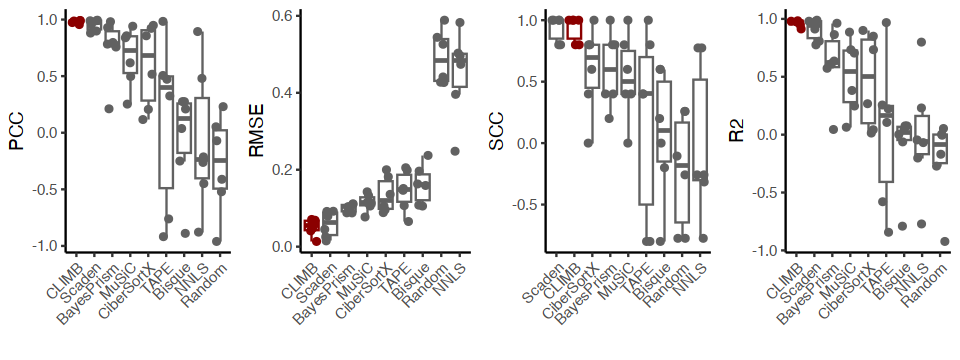

In [10]:
options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
#pdf('results/fig3/boxplot_psample_4metrics_invitro.pdf', width=8, height=3) ; g ; dev.off()
g

Results for the in-vitro experiment can be found in `Fig2_XX`

# AML cross-dataset deconvolution analysis

Here we will load 3 remaining analysis in AML context:
- Van Galen > Naldini (AML): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Van Galen was used as a reference to deconvolute the pseudo-bulks made from Naldini dataset, after data integration and transfering of cell subtype labels from Van Galen to Naldini.
- Naldini > Van Galen (AML): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Naldini was used as a reference to deconvolute the pseudo-bulks made from Van Galen dataset, after data integration and transfering of cell subtype labels from Naldini to Van Galen.
- 200 simulated bulks (AML): Simulated dataset of 200 bulks made from Van Galen scRNA-seq dataset.

In [71]:
aml.na2vg = make_all_metrics(load_all_props('data/pseudobulks_climb/AML_na2vg', include_cibersortx=T), 'data/pseudobulks_climb/AML_na2vg/true_prop.csv') #, include_cibersortx=T
aml.vg2na = make_all_metrics(load_all_props('data/pseudobulks_climb/AML_vg2na', include_cibersortx=T), 'data/pseudobulks_climb/AML_vg2na/true_prop.csv')
aml.vg2na_200sim =  make_all_metrics(load_all_props('data/simulation_aml/tables_vg2na/', include_cibersortx=T), 'data/simulation_aml/tables_vg2na/true_prop.csv')

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [72]:
# print an example
aml.na2vg$CLIMB$PCC_per_sample

[1] 0.8498359 0.8991120 0.8903339 0.6175969 0.8993191 0.8746554 0.7230635
 [8] 0.9105132 0.7152195 0.7257924 0.9422487 0.8045535 0.8651698 0.8182096
[15] 0.8922834 0.8793009

## Plot the comparative results 

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



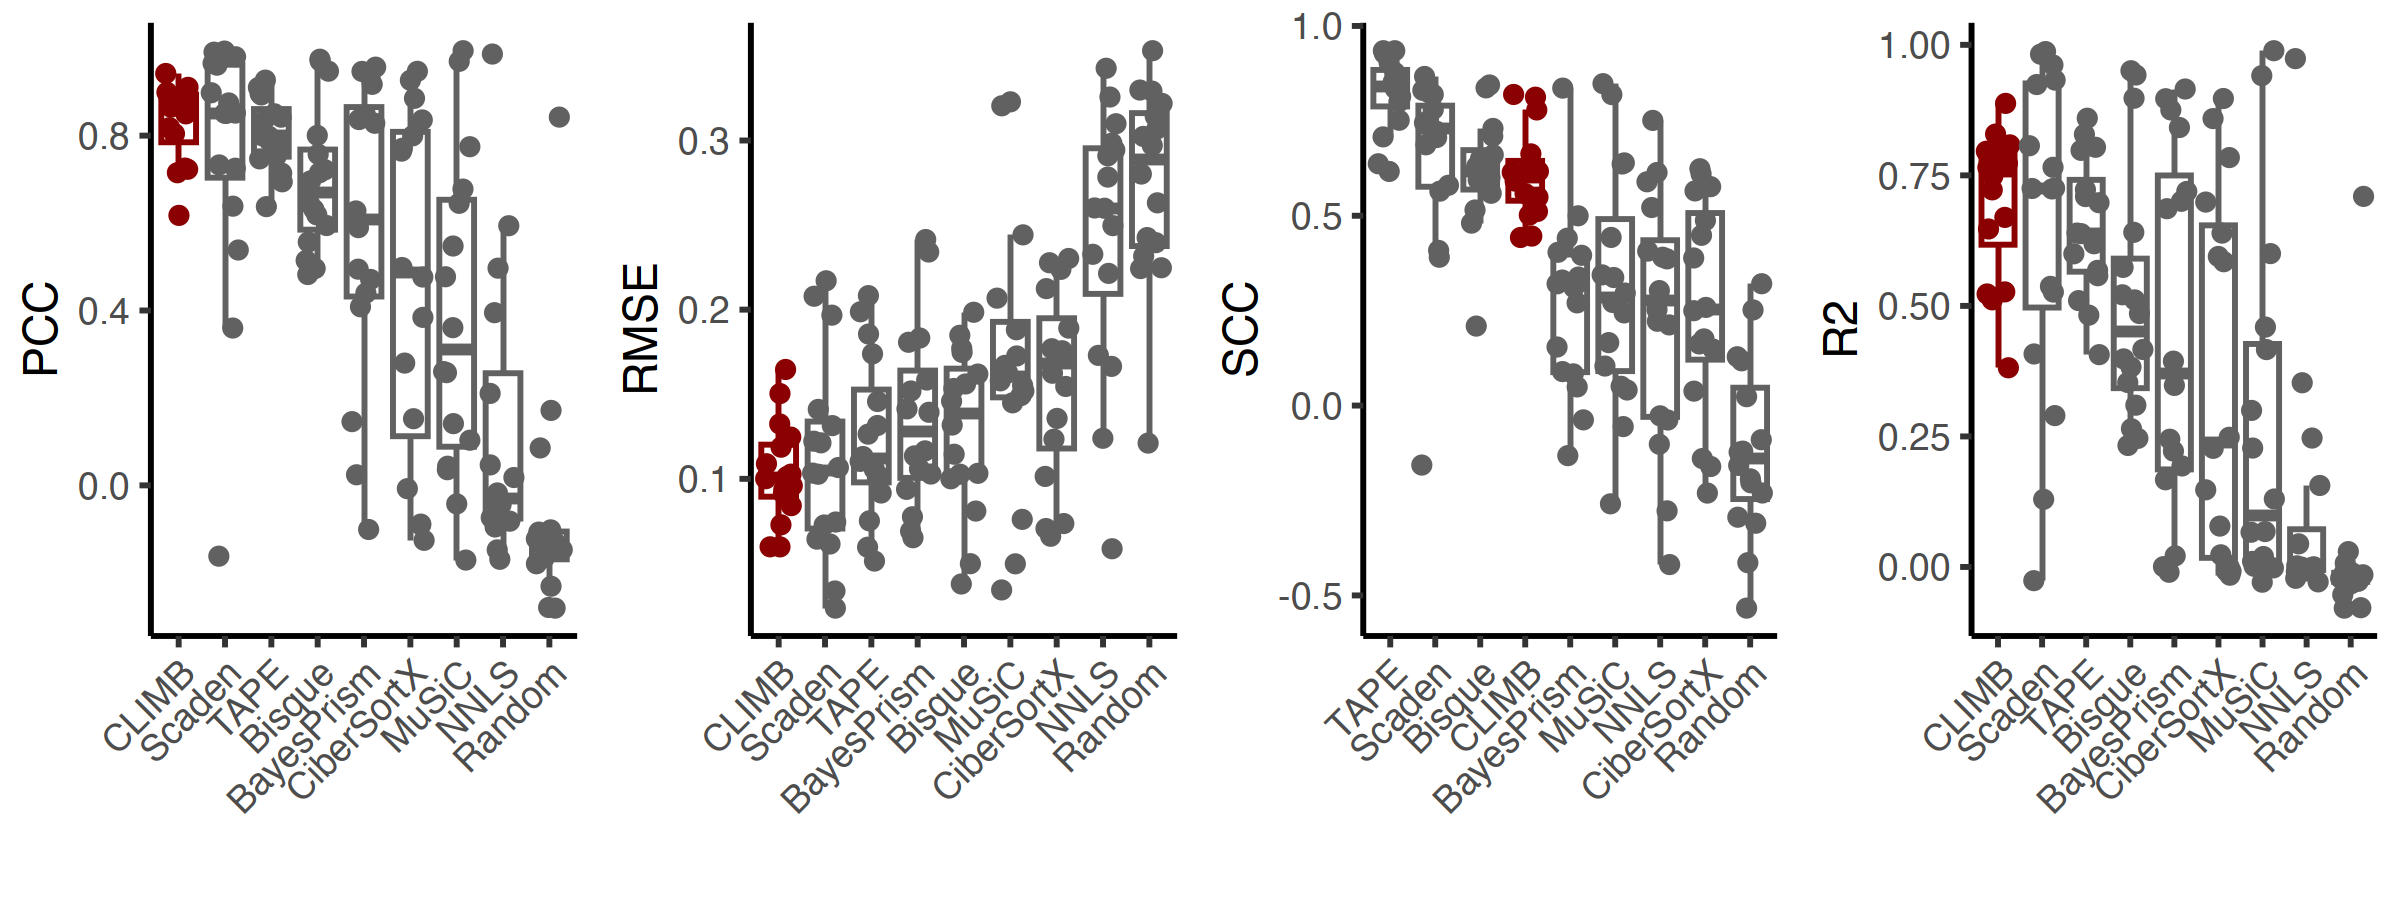

In [73]:
### Naldini > Van Galen analysis

# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(aml.na2vg, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(aml.na2vg, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(aml.na2vg, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(aml.na2vg, type.err='RMSE_per_sample') # RMSE

options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
#pdf('results/fig3/boxplot_psample_PCC_RMSE_na2vg.pdf', width=4.5, height=3.5) ; g ; dev.off()
g

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



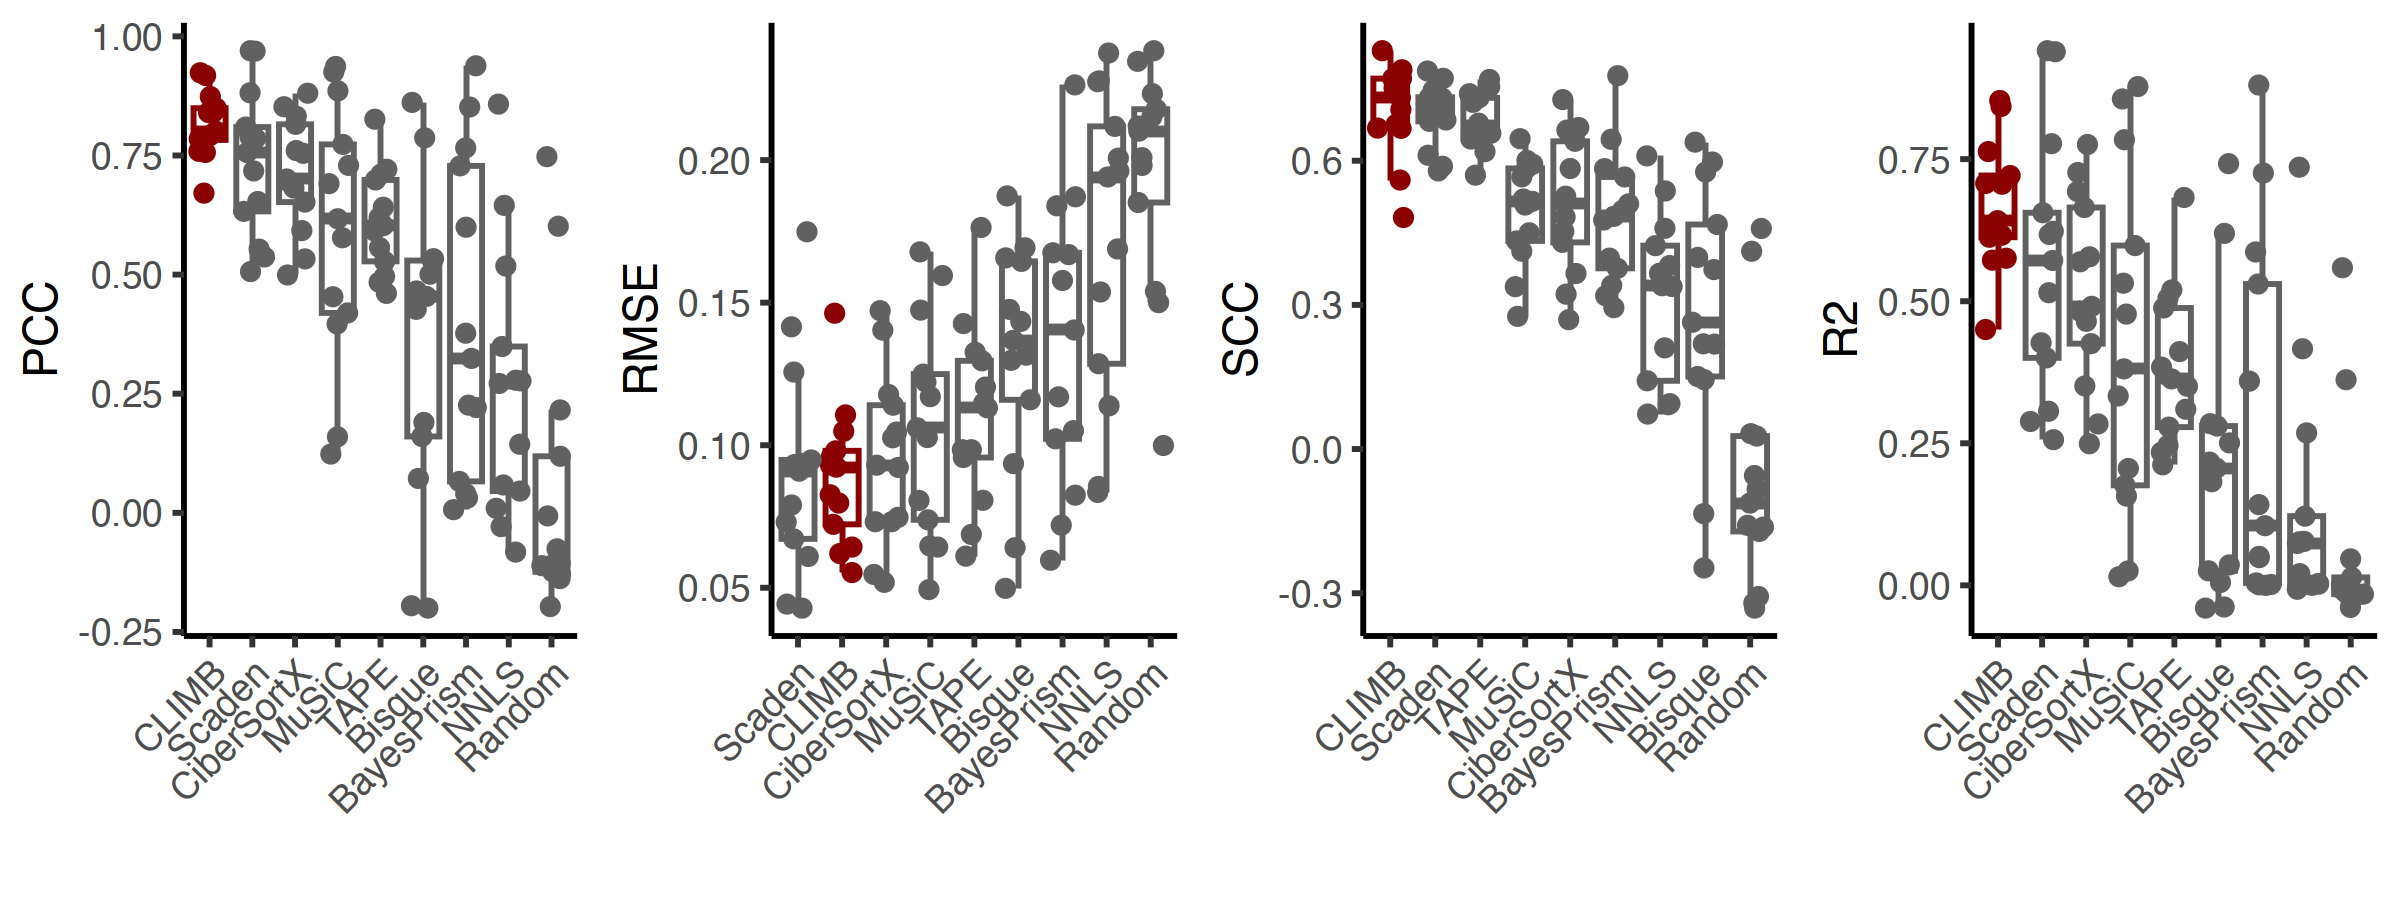

In [74]:
### Van Galen > Naldini 

# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(aml.vg2na, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(aml.vg2na, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(aml.vg2na, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(aml.vg2na, type.err='RMSE_per_sample') # RMSE

options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
#pdf('results/fig3/boxplot_psample_PCC_RMSE_vg2na.pdf', width=4.5, height=3.5) ; g ; dev.off()
g

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



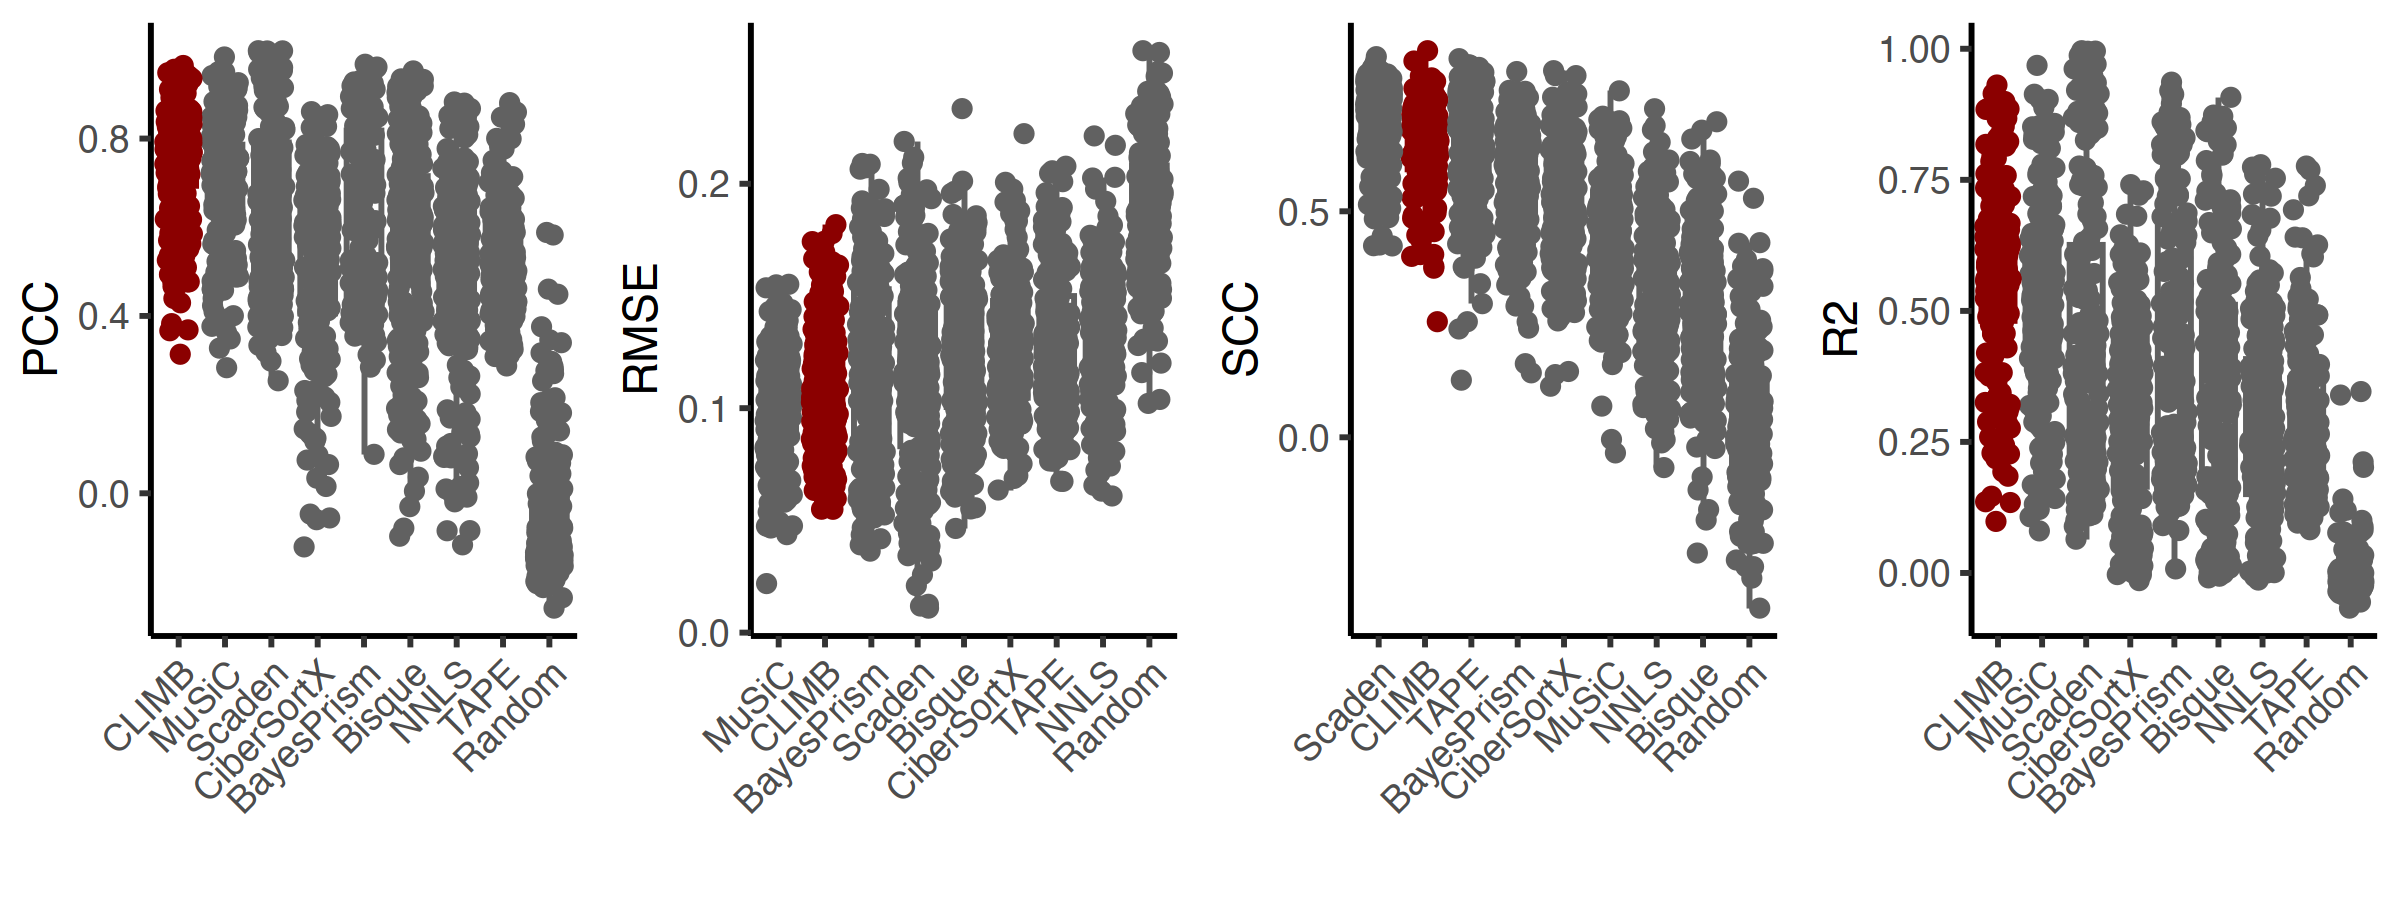

In [75]:
### 200 Simulated bulks

# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(aml.vg2na_200sim, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(aml.vg2na_200sim, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(aml.vg2na_200sim, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(aml.vg2na_200sim, type.err='RMSE_per_sample') # RMSE

options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
#pdf('results/fig3/boxplot_psample_PCC_RMSE_vg2na_200sim.pdf', width=6, height=3.5) ; g ; dev.off()
g

Now we assemble the results from the 4 AML analysis and make a single figure

In [76]:
# Compute Rankings with all four metrics per sample
ranks.vg2na = rank_all_metrics(aml.vg2na)
ranks.na2vg = rank_all_metrics(aml.na2vg)
ranks.vg2na_200sim = rank_all_metrics(aml.vg2na_200sim)
ranks.invitro = rank_all_metrics(invitro)

In [77]:
df_all = cbind(ranks.vg2na, ranks.na2vg, ranks.vg2na_200sim, ranks.invitro)
mat_ranks = as.matrix(df_all)
df_all$mean_overall = rowMeans(mat_ranks)
df_all$std_overall = rowSds(mat_ranks)
df_all$mean_inter1 = rowMeans(as.matrix(ranks.vg2na))
df_all$mean_inter2 = rowMeans(as.matrix(ranks.na2vg))
df_all$mean_inter3 = rowMeans(as.matrix(ranks.vg2na_200sim))
df_all$mean_inter4 = rowMeans(as.matrix(ranks.invitro))

In [78]:
df_all$method = rownames(df_all)
df_all$method = factor(df_all$method, levels=rev(df_all$method[order(df_all$mean_overall)]))
df_all = df_all[,13:dim(df_all)[2]]

In [79]:
head(df_all)

rank_rmse rank_pcc rank_scc rank_r2 mean_overall std_overall
CLIMB      1         1        1.5      1       1.40625      0.8003905  
Scaden     2         2        1.5      2       2.09375      0.7352721  
TAPE       6         6        6.0      6       4.87500      2.0289570  
CiberSortX 5         5        3.0      5       4.87500      1.5000000  
BayesPrism 3         3        4.0      3       4.75000      1.4375906  
MuSiC      4         4        5.0      4       4.37500      1.7464249  
           mean_inter1 mean_inter2 mean_inter3 mean_inter4 method    
CLIMB      1.25        1.75        1.50        1.125       CLIMB     
Scaden     1.75        2.00        2.75        1.875       Scaden    
TAPE       4.50        2.50        6.50        6.000       TAPE      
CiberSortX 3.50        6.75        4.75        4.500       CiberSortX
BayesPrism 6.75        4.75        4.25        3.250       BayesPrism
MuSiC      4.00        6.50        2.75        4.250       MuSiC

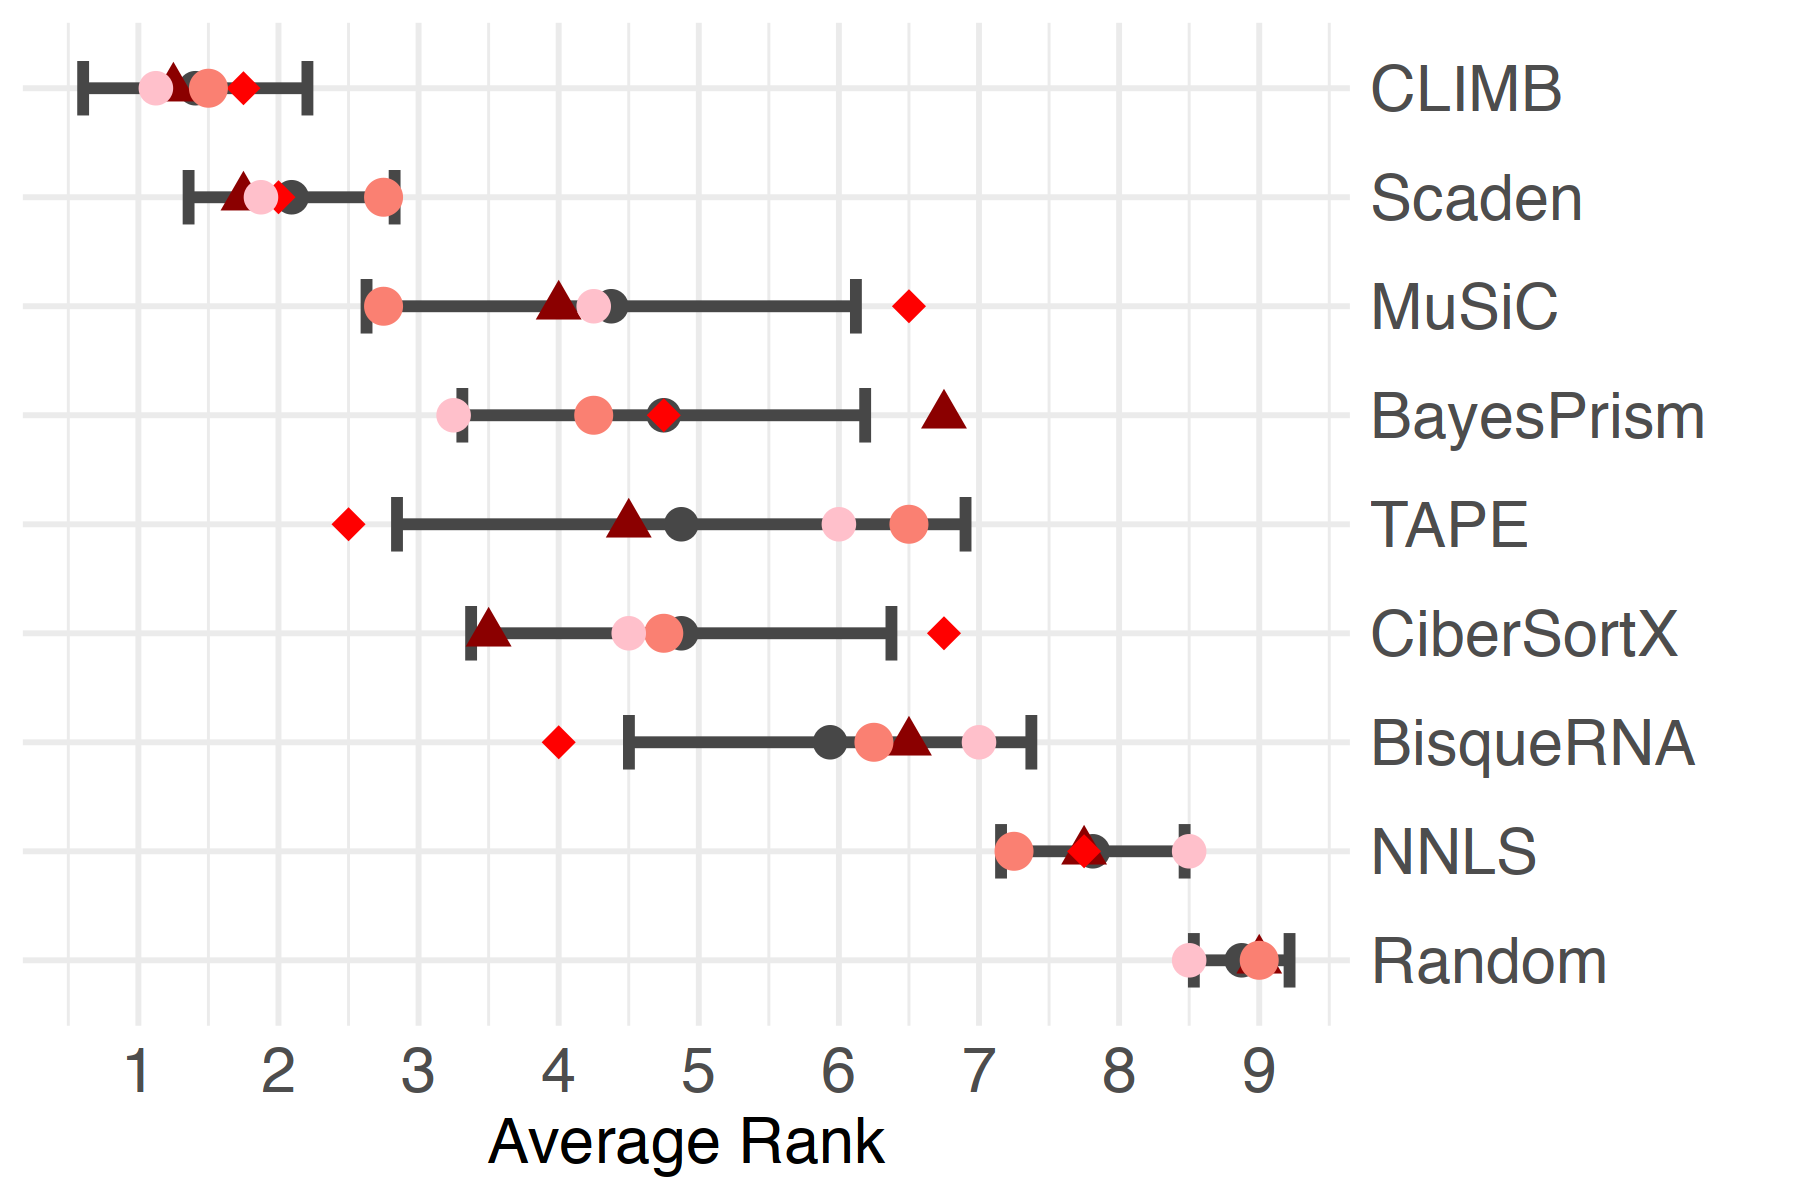

In [80]:
options(repr.plot.width=6, repr.plot.height=4)
g <- ggplot() + geom_errorbar(data=df_all, aes(y=method, xmin=mean_overall-std_overall, xmax=mean_overall+std_overall), width=0.5, size=1, color="grey28") +
    geom_point(data=df_all, aes(x=mean_overall, y=method), , size=3.0, color='grey28') + 
    geom_point(data=df_all, aes(x=mean_inter1, y=method), size=3.5, color='darkred', shape=17) +
    geom_point(data=df_all, aes(x=mean_inter2, y=method), size=3.5, color='red', shape=18) +
    geom_point(data=df_all, aes(x=mean_inter3, y=method), size=3.5, color='salmon') +
    geom_point(data=df_all, aes(x=mean_inter4, y=method), size=3.0, color='pink') +
    scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 15), text=element_text(size = 15)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "right")
#pdf('results/fig3/rankings_AML_context_crossdatasets_4analysis.pdf', width=4.5, height=4.5) ; g ; dev.off()
g

In [81]:
# Statistics comparing CLIMB versus other methods ranks with a wilcoxon test
aml.ranks = cbind(ranks.vg2na, ranks.na2vg, ranks.vg2na_200sim)
rownames(aml.ranks[2,])
suppressWarnings(wilcox.test(num(aml.ranks[1,]), num(aml.ranks[2,]))$p.value)
rownames(aml.ranks[3,])
suppressWarnings(wilcox.test(num(aml.ranks[1,]), num(aml.ranks[3,]))$p.value)
rownames(aml.ranks[4,])
suppressWarnings(wilcox.test(num(aml.ranks[1,]), num(aml.ranks[4,]))$p.value)
rownames(aml.ranks[5,])
suppressWarnings(wilcox.test(num(aml.ranks[1,]), num(aml.ranks[5,]))$p.value)
rownames(aml.ranks[6,])
suppressWarnings(wilcox.test(num(aml.ranks[1,]), num(aml.ranks[6,]))$p.value)
rownames(aml.ranks[7,])
suppressWarnings(wilcox.test(num(aml.ranks[1,]), num(aml.ranks[7,]))$p.value)
rownames(aml.ranks[8,])
suppressWarnings(wilcox.test(num(aml.ranks[1,]), num(aml.ranks[8,]))$p.value)

[1] "Scaden"

[1] 0.02670921

[1] "TAPE"

[1] 0.000478485

[1] "CiberSortX"

[1] 6.73079e-05

[1] "BayesPrism"

[1] 3.82561e-05

[1] "MuSiC"

[1] 0.0007098823

[1] "NNLS"

[1] 1.83895e-05

[1] "BisqueRNA"

[1] 3.857e-05

## Analysis of cellular proportions in AML

We will make now a few additional figures, taking Van Galen > Naldini and Naldini > Van Galen analysis. 

In [100]:
# Van Galen > Naldini analysis: Load true and deconvoluted proprotions
all_props.vg2na = load_all_props('data/pseudobulks_climb/AML_vg2na', include_cibersortx = T)
true_prop.vg2na = read.csv('data/pseudobulks_climb/AML_vg2na/true_prop.csv', row.names='X')

# Make a flattened data.frame with reshape2::melt function as requested by ggplot2
melt_dots.vg2na = cbind(melt(all_props.vg2na$CLIMB), melt(as.matrix(true_prop.vg2na)))[,c(1,2,3,6)]
colnames(melt_dots.vg2na) = c('sample', 'celltype', 'climb', 'true')
melt_dots.vg2na$analysis = 'vg2na'

# Do the same with Scaden proportions 
melt_dots.scaden.vg2na = cbind(melt(all_props.vg2na$Scaden), melt(as.matrix(true_prop.vg2na)))[,c(1,2,3,6)]
colnames(melt_dots.scaden.vg2na) = c('sample', 'celltype', 'scaden', 'true')
melt_dots.scaden.vg2na$analysis = 'vg2na'

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [101]:
# Do it again for Naldini > Van Galen analysis
all_props.na2vg = load_all_props('data/pseudobulks_climb/AML_na2vg', include_cibersortx = T)
true_prop.na2vg = read.csv('data/pseudobulks_climb/AML_na2vg/true_prop.csv', row.names='X')

# Extract CLIMB and Scaden proportions and make flattened data.frame with reshape2::melt
melt_dots.na2vg = cbind(melt(all_props.na2vg$CLIMB), melt(as.matrix(true_prop.na2vg)))[,c(1,2,3,6)]
colnames(melt_dots.na2vg) = c('sample', 'celltype', 'climb', 'true')
melt_dots.na2vg$analysis = 'na2vg'
melt_dots.scaden.na2vg = cbind(melt(all_props.na2vg$Scaden), melt(as.matrix(true_prop.na2vg)))[,c(1,2,3,6)]
colnames(melt_dots.scaden.na2vg) = c('sample', 'celltype', 'scaden', 'true')
melt_dots.scaden.na2vg$analysis = 'na2vg'

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [102]:
# Assemble results from both 'Van Galen > Naldini' and 'Naldini > Van Galen' analysis
melt_dots = rbind(melt_dots.vg2na, melt_dots.na2vg) # CLIMB 
melt_dots.scaden = rbind(melt_dots.scaden.vg2na, melt_dots.scaden.na2vg) # Scaden 

Next we make scatter plot of true versus deconvoluted cell subtype proportions, merging analysis of Van Galen > Naldini and Naldini > Van Galen. We will do it for CLIMB and Scaden methods. 

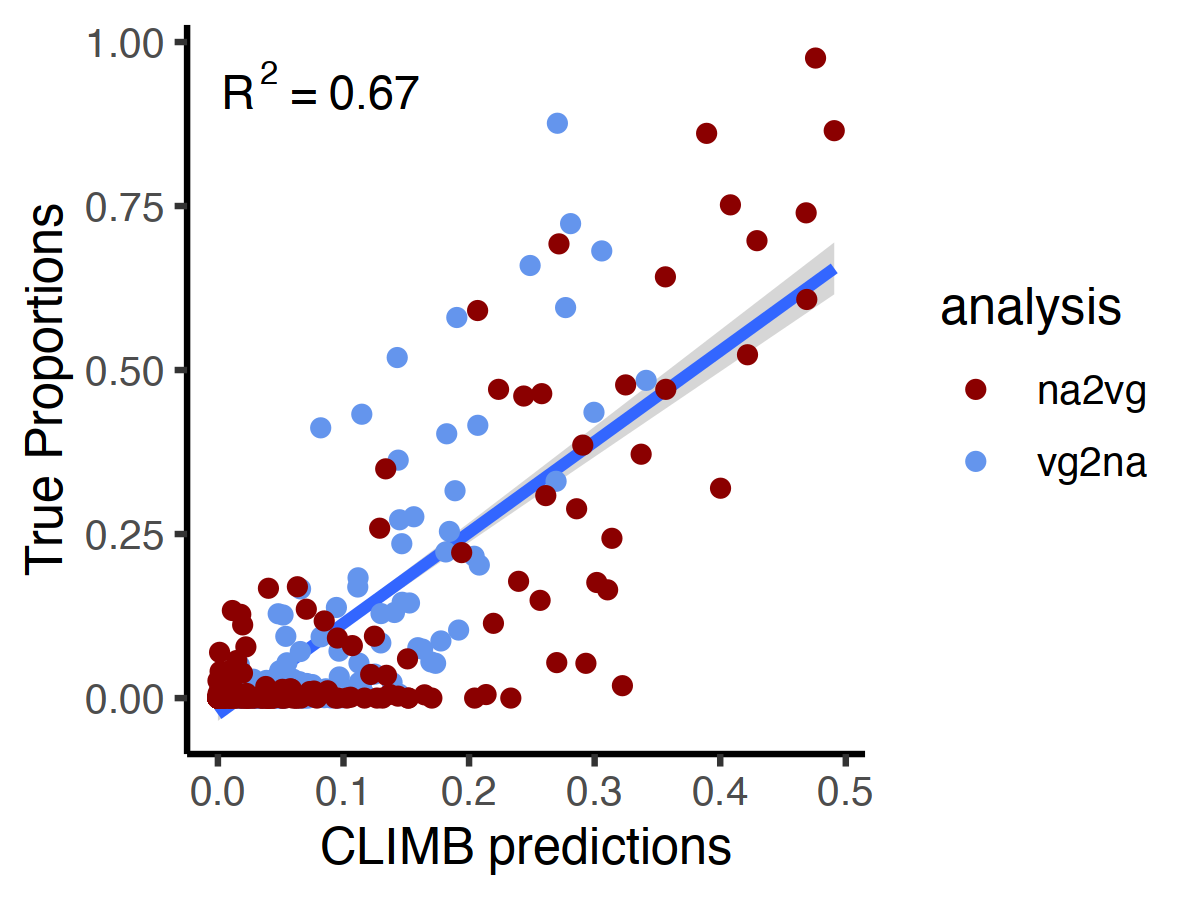

In [104]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res=300)
g<- ggplot(data=melt_dots) + 
    scale_color_manual(values=c('darkred', 'cornflowerblue')) + theme_classic2() +
    stat_poly_line(aes(y=true, x=climb)) + stat_poly_eq(aes(y=true, x=climb)) +
    geom_point(aes(x=climb, y=true, color=analysis)) + 
    ylab('True Proportions') + xlab('CLIMB predictions')
#pdf('results/fig3/scatter_climb_aml_crossdata.pdf', width=4, height=3) ; g ; dev.off()
g

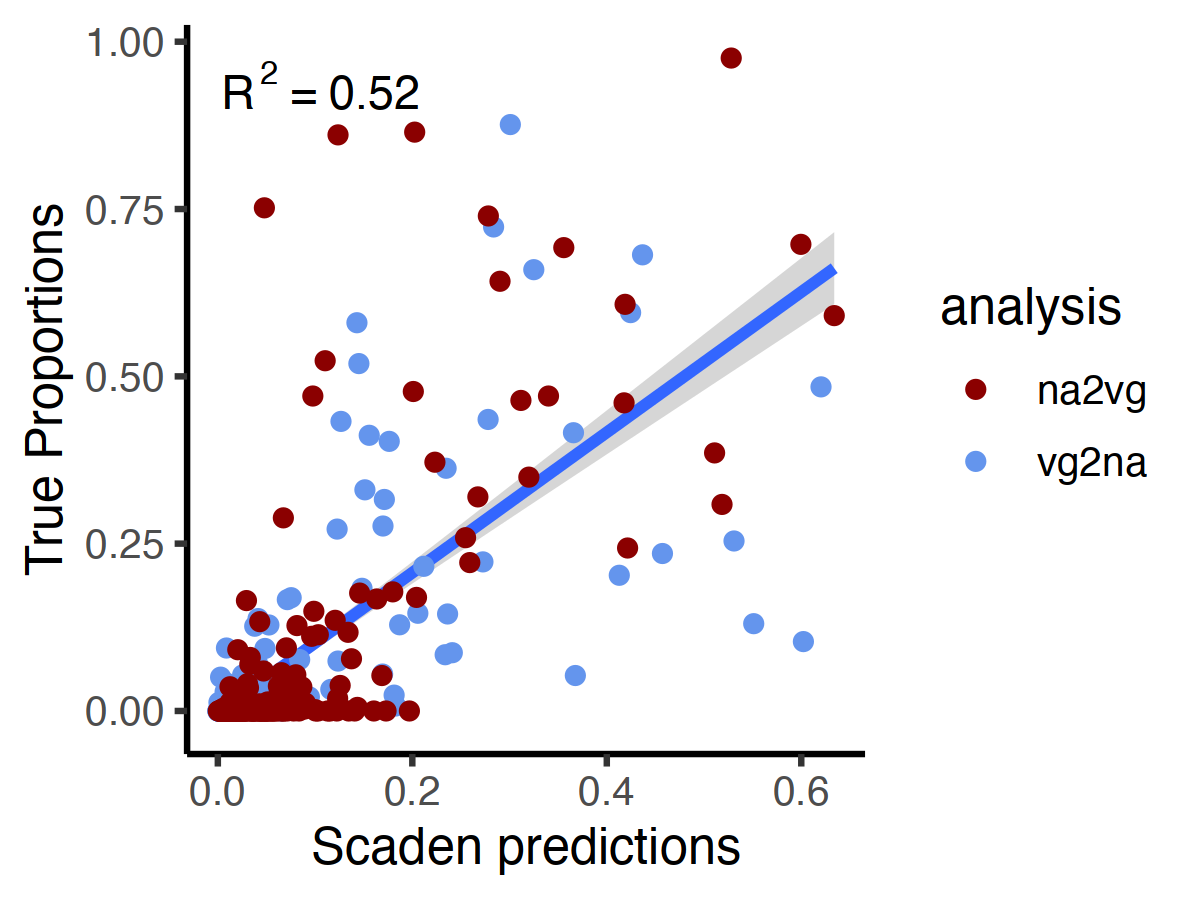

In [105]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res=300)
g<- ggplot(data=melt_dots.scaden) + 
    scale_color_manual(values=c('darkred', 'cornflowerblue')) + theme_classic2() +
    stat_poly_line(aes(y=true, x=scaden)) + stat_poly_eq(aes(y=true, x=scaden)) +
    geom_point(aes(x=scaden, y=true, color=analysis)) + 
    ylab('True Proportions') + xlab('Scaden predictions')
#pdf('results/fig3/scatter_Scaden_aml_crossdata.pdf', width=4, height=3) ; g ; dev.off()
g

## Analysis of HSC-like proportions 

We put an emphasis on HSC-like cell subtype in AML, as this cell subtype probably emcompass the Leukemic Stem Cells, a cell subtype of high clinical interest. In the analysis Van Galen > Naldini, we have deconvoluted proportions of HSC-like in 13 samples, we can thus get correlation metrics for HSC-like.

In [106]:
# Compute accuracy for HSC-like cell-type in Van Galen > Naldini context
all_hsclike_cor = c(cor(all_props.vg2na$CLIMB[,'HSClike'], true_prop.vg2na[,'HSClike']),
                    cor(all_props.vg2na$CiberSortX[,'HSClike'], true_prop.vg2na[,'HSClike']),
                    cor(all_props.vg2na$Scaden[,'HSClike'], true_prop.vg2na[,'HSClike']),
                    cor(all_props.vg2na$TAPE[,'HSClike'], true_prop.vg2na[,'HSClike']),
                    cor(all_props.vg2na$BayesPrism[,'HSClike'], true_prop.vg2na[,'HSClike']),
                    cor(all_props.vg2na$MuSiC[,'HSClike'], true_prop.vg2na[,'HSClike']),
                    cor(all_props.vg2na$NNLS[,'HSClike'], true_prop.vg2na[,'HSClike']),
                    cor(all_props.vg2na$BisqueRNA[,'HSClike'], true_prop.vg2na[,'HSClike']),
                    cor(all_props.vg2na$Random[,'HSClike'], true_prop.vg2na[,'HSClike']))
df_pcc = data.frame(pcc=all_hsclike_cor, method=names(all_props.vg2na)) # we remove CLIMB with no weight
# Reorder factors
df_pcc$method = factor(df_pcc$method, levels=df_pcc$method[order(df_pcc$pcc)])

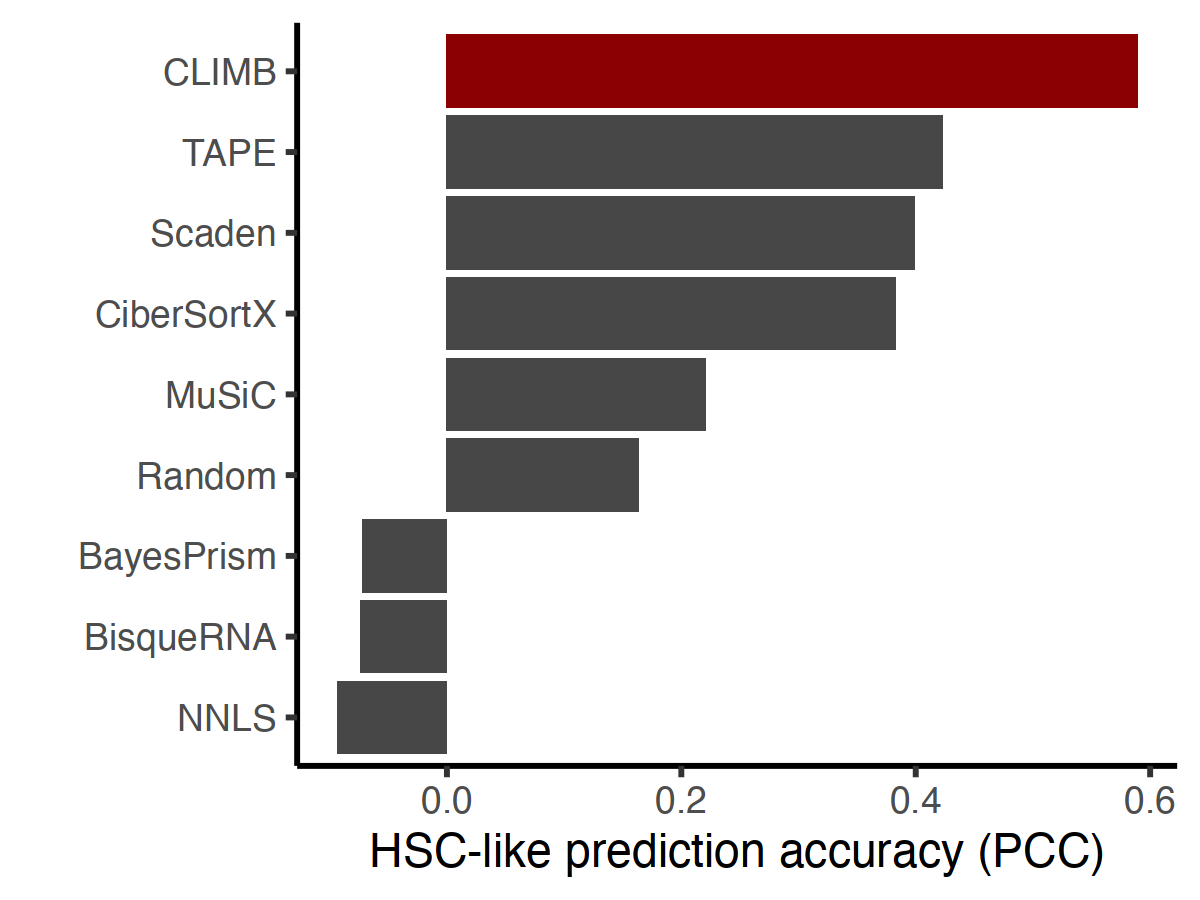

In [107]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res=300)
g <- ggplot(df_pcc) + geom_bar(aes(y=method, x=pcc, fill=method), stat="identity") + theme_classic() + 
    xlab('HSC-like prediction accuracy (PCC)') + ylab('') +
    scale_fill_manual(values = ifelse(grepl('CLIMB', levels(df_pcc$method)), 'darkred', 'grey28'), guide="none")
#pdf('results/fig3/barplot_hsclike_accuracy_vg2na.pdf', width=4, height=3) ; g ; dev.off()
g

This analysis can unfortunately not be done in the Naldini > Van Galen context as we use Naldini's cell-type. Naldini's cell-type does not distinguish cancer from normal cells (Van Galen used single-cell DNA-seq to distinguish them). Naldini contains CD34+ HSC cells (normal), but zero of these cells were transfered to Van Galen by Seurat's integration.

# CRC - color-rectal cancer cross-dataset analysis

We know perform the cross-dataset deconvolution analysis for two colorectal cancer dataset: Lee et al. (). and Khaliq et al. (). 
- Lee > Khaliq (CRC): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Lee was used as a reference to deconvolute the pseudo-bulks made from Khaliq dataset, after data integration and transfering of cell subtype labels from Lee to Khaliq. 
- Khaliq > Lee (CRC): Cross-dataset pseudo-bulk analysis where the scRNA-seq dataset from Khaliq was used as a reference to deconvolute the pseudo-bulks made from Lee dataset, after data integration and transfering of cell subtype labels from Lee to Khaliq (labels from Lee were used here as we did not find good labels for Khaliq dataset).

In [421]:
# Load props and compute all metrics
out_dir = 'data/pseudobulks_climb/CRC_kha2lee'
crc.kha2lee = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
out_dir = 'data/pseudobulks_climb/CRC_lee2kha'
crc.lee2kha = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
# Compute rank over 4 metrics
ranks.kha2lee = rank_all_metrics(crc.kha2lee)
ranks.lee2kha = rank_all_metrics(crc.lee2kha)

Checking that all tables have the same cell-type labels: FALSE

Checking that all tables has the same sample names: TRUE

Checking that all tables have the same cell-type labels: FALSE

Checking that all tables has the same sample names: TRUE



In [422]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(crc.kha2lee, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(crc.kha2lee, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(crc.kha2lee, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(crc.kha2lee, type.err='RMSE_per_sample') # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

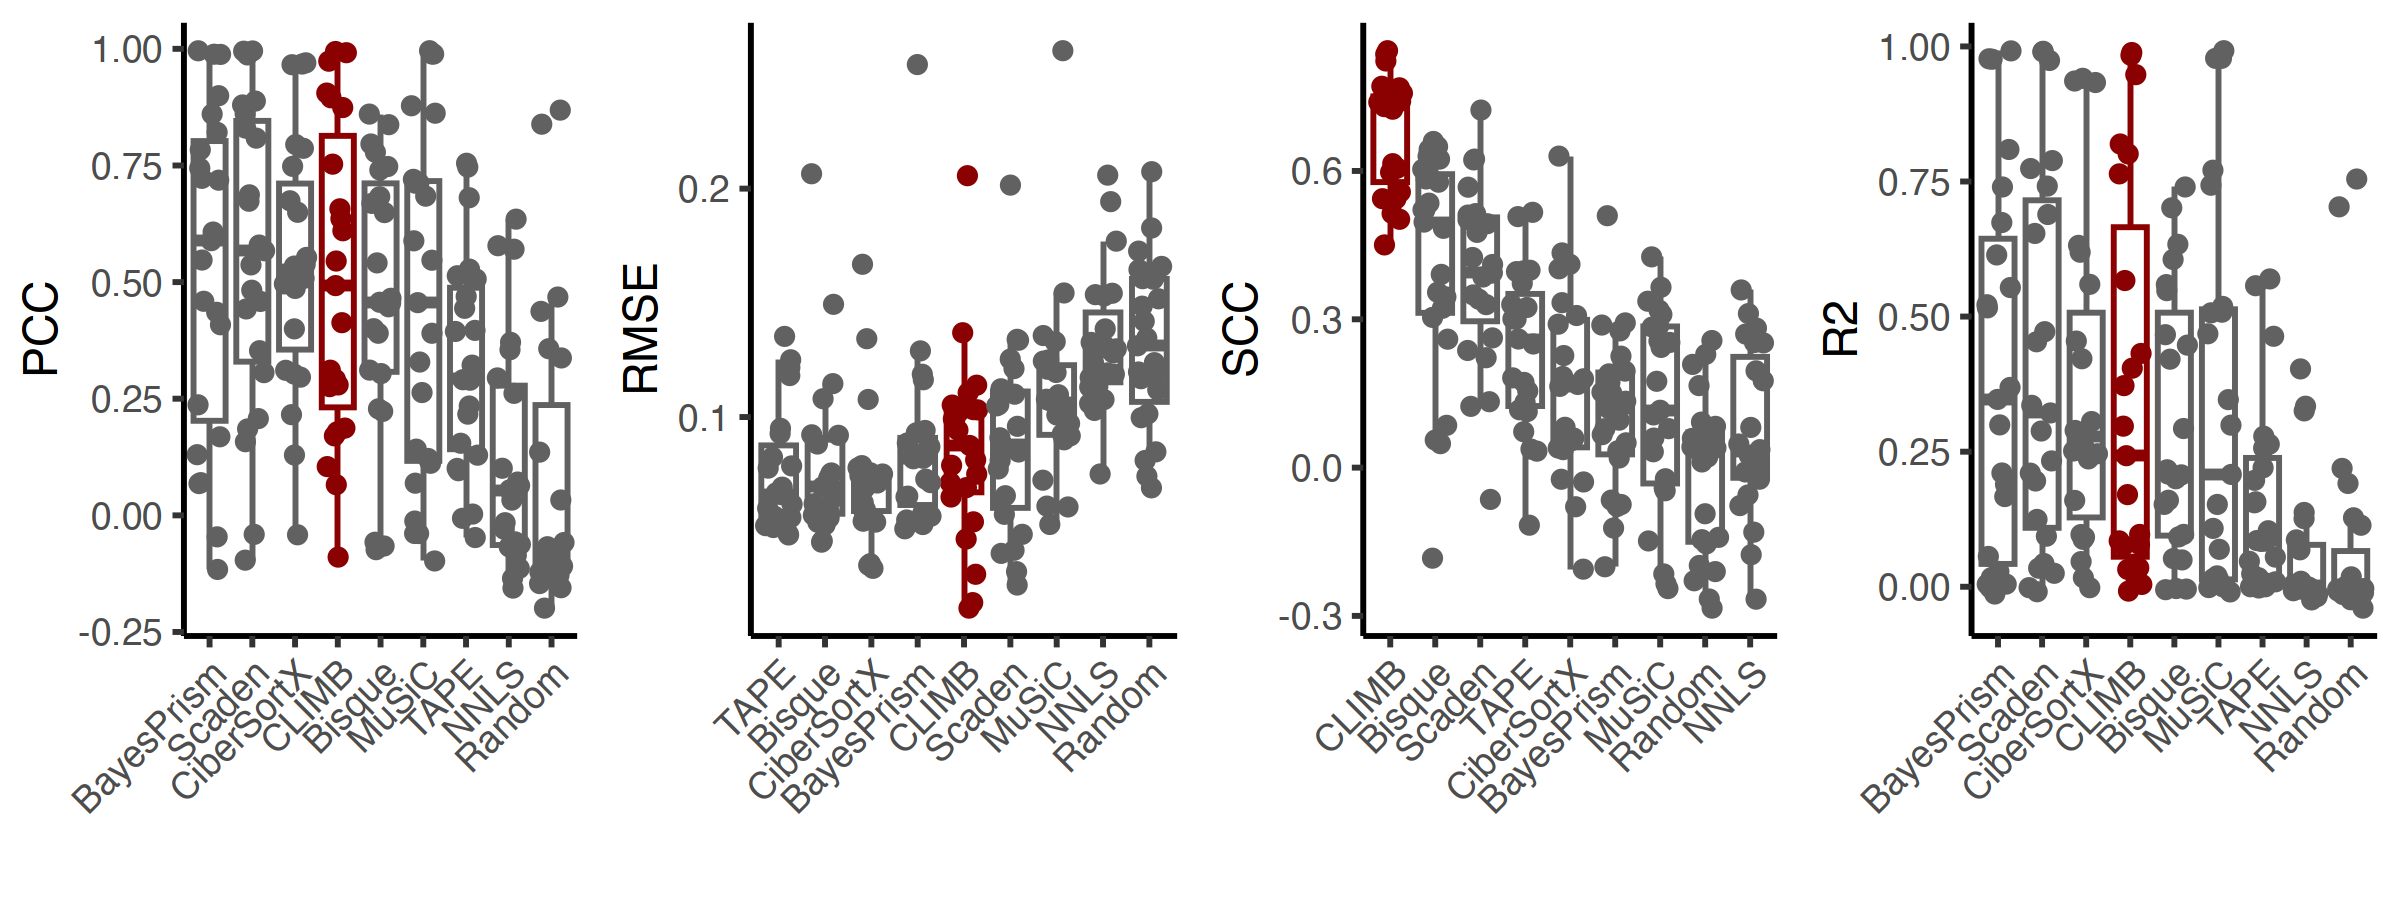

In [425]:
options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
pdf('results/fig3/boxplot_psample_4metrics_kha2lee.pdf', width= 8, height=3) ; g ; dev.off()
g

In [426]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(crc.lee2kha, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(crc.lee2kha, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(crc.lee2kha, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(crc.lee2kha, type.err='RMSE_per_sample') # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

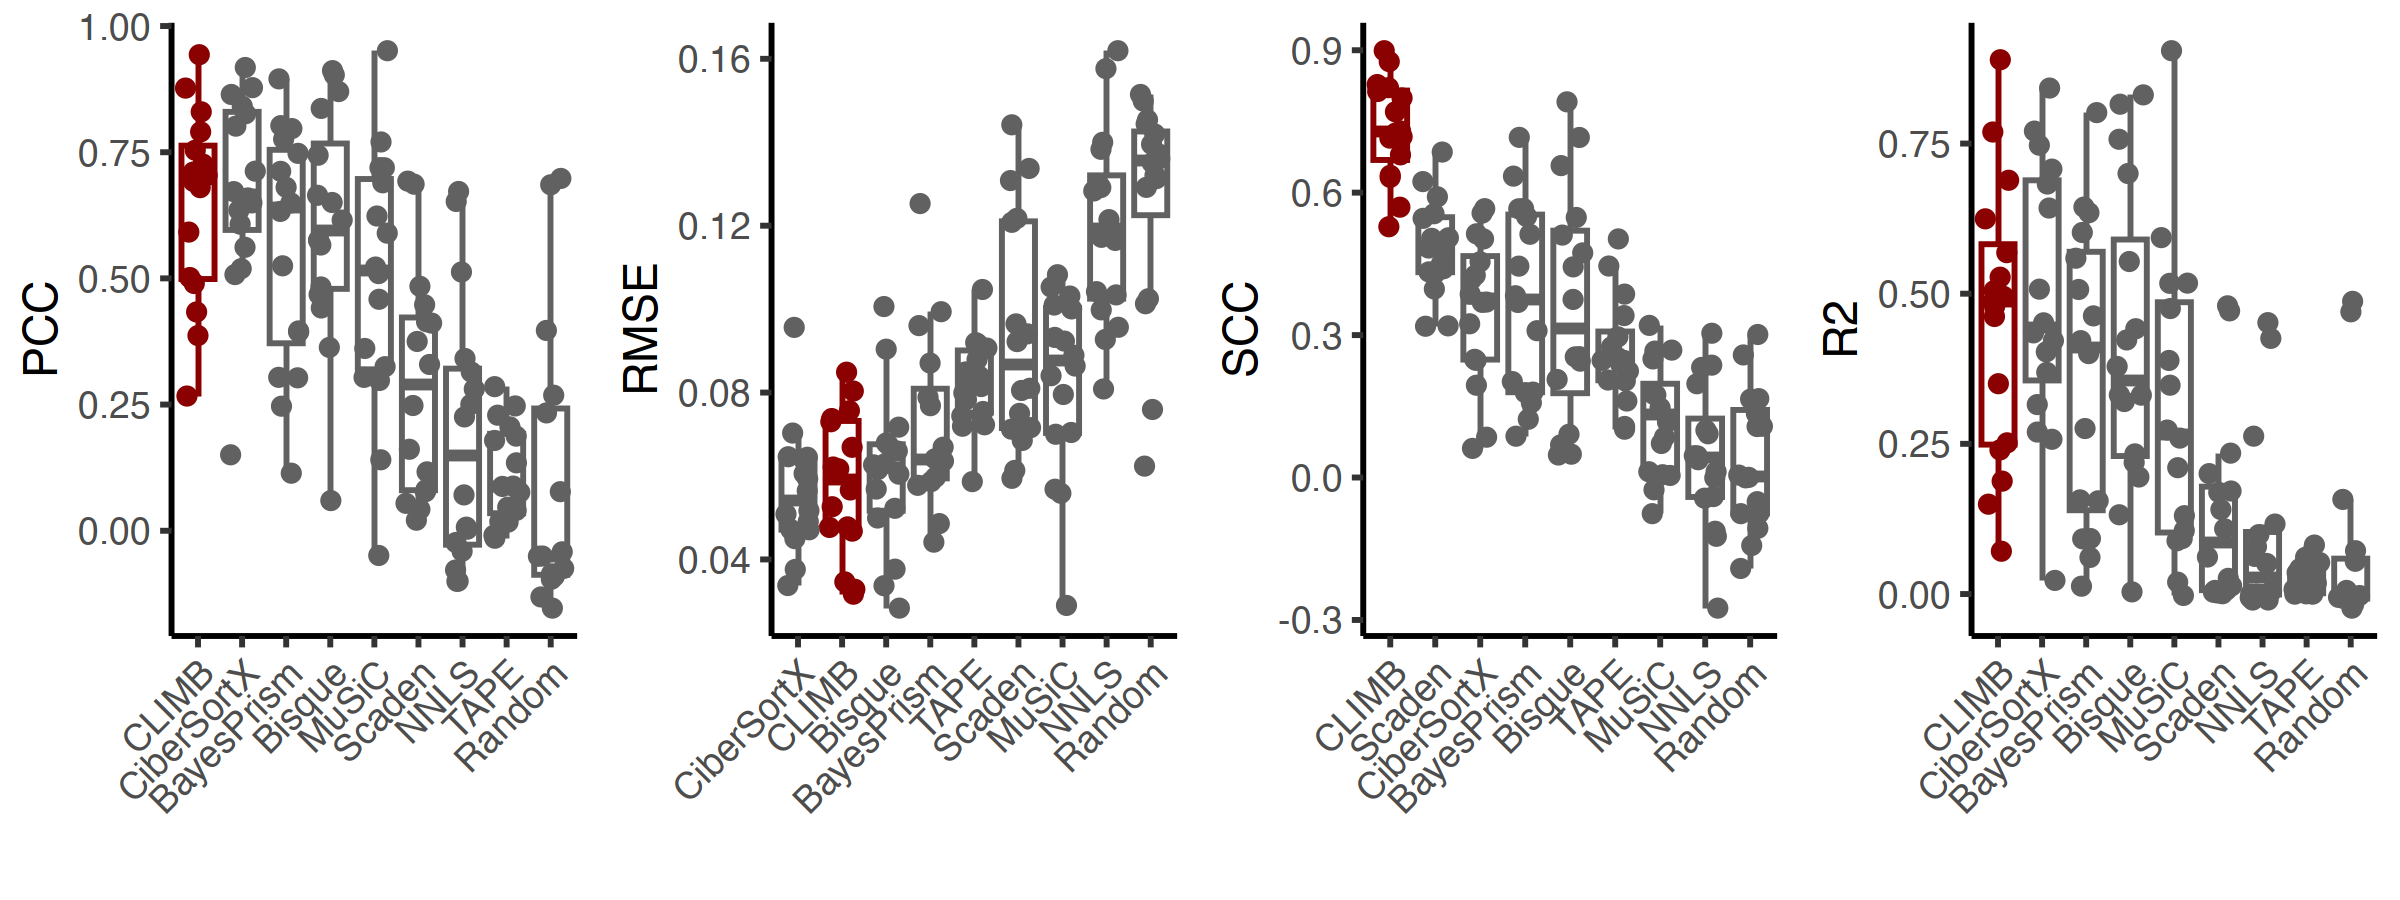

In [427]:
options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
pdf('results/fig3/boxplot_psample_4metrics_lee2kha.pdf', width= 8, height=3) ; g ; dev.off()
g

pdf 
  2

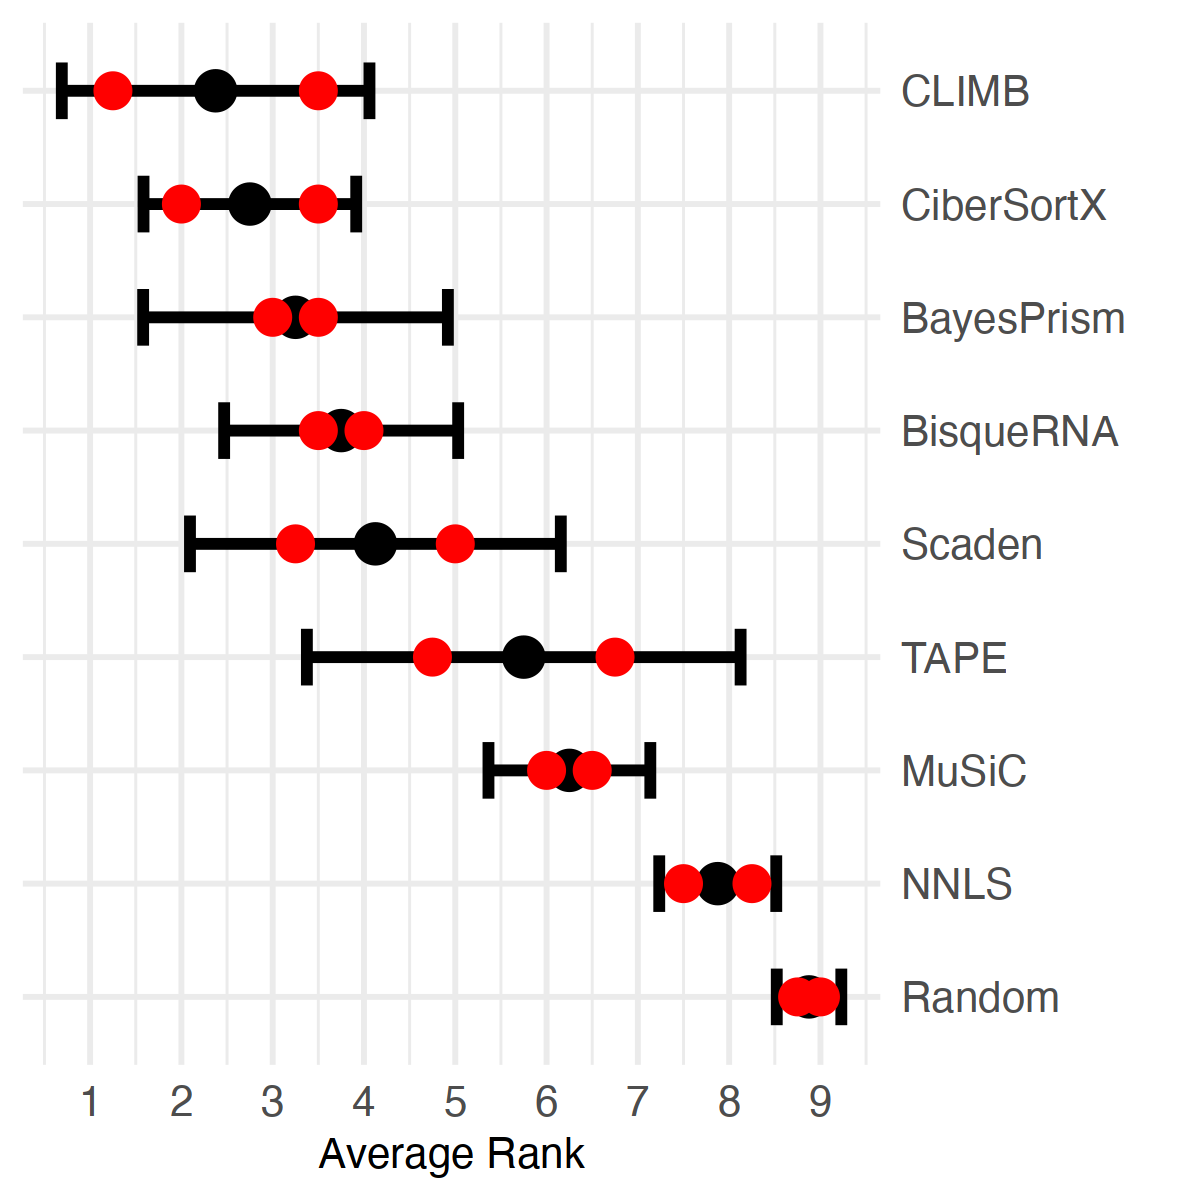

In [428]:
df_all.crc = cbind(ranks.kha2lee, ranks.lee2kha)
mat_ranks = as.matrix(df_all.crc)
df_all.crc$mean_overall = rowMeans(mat_ranks)
df_all.crc$std_overall = rowSds(mat_ranks)
df_all.crc$mean_inter1 = rowMeans(as.matrix(ranks.kha2lee))
df_all.crc$mean_inter2 = rowMeans(as.matrix(ranks.lee2kha))
df_all.crc$method = rownames(df_all.crc)
df_all.crc$method = factor(df_all.crc$method, levels=rev(df_all.crc$method[order(df_all.crc$mean_overall)]))
df_all.crc = df_all.crc[,(dim(df_all.crc)[2]-10):dim(df_all.crc)[2]]
options(repr.plot.width=4, repr.plot.height=4)
g <- ggplot() + geom_errorbar(data=df_all.crc, aes(y=method, xmin=mean_overall-std_overall, xmax=mean_overall+std_overall), width=0.5, size=1, color="black") +
    geom_point(data=df_all.crc, aes(x=mean_overall, y=method), size=4.0, color='black') + 
    geom_point(data=df_all.crc, aes(x=mean_inter1, y=method), size=3.5, color='red') +
    geom_point(data=df_all.crc, aes(x=mean_inter2, y=method), size=3.5, color='red') +
    scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 10), text=element_text(size = 10)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "right")
pdf('results/fig3/rank_dots_4metrics_CRC.pdf', width=3, height=3) ; g ; dev.off()
g

## Melanoma

In [429]:
out_dir = 'data/pseudobulks_climb/MEL_jer2tir/'
mel.jer2tir = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
out_dir = 'data/pseudobulks_climb/MEL_tir2jer/'
mel.tir2jer = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
# Compute rank over 4 metrics
ranks.jer2tir = rank_all_metrics(mel.jer2tir)
ranks.tir2jer = rank_all_metrics(mel.tir2jer)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [430]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(mel.tir2jer, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(mel.tir2jer, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(mel.tir2jer, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(mel.tir2jer, type.err='RMSE_per_sample') # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

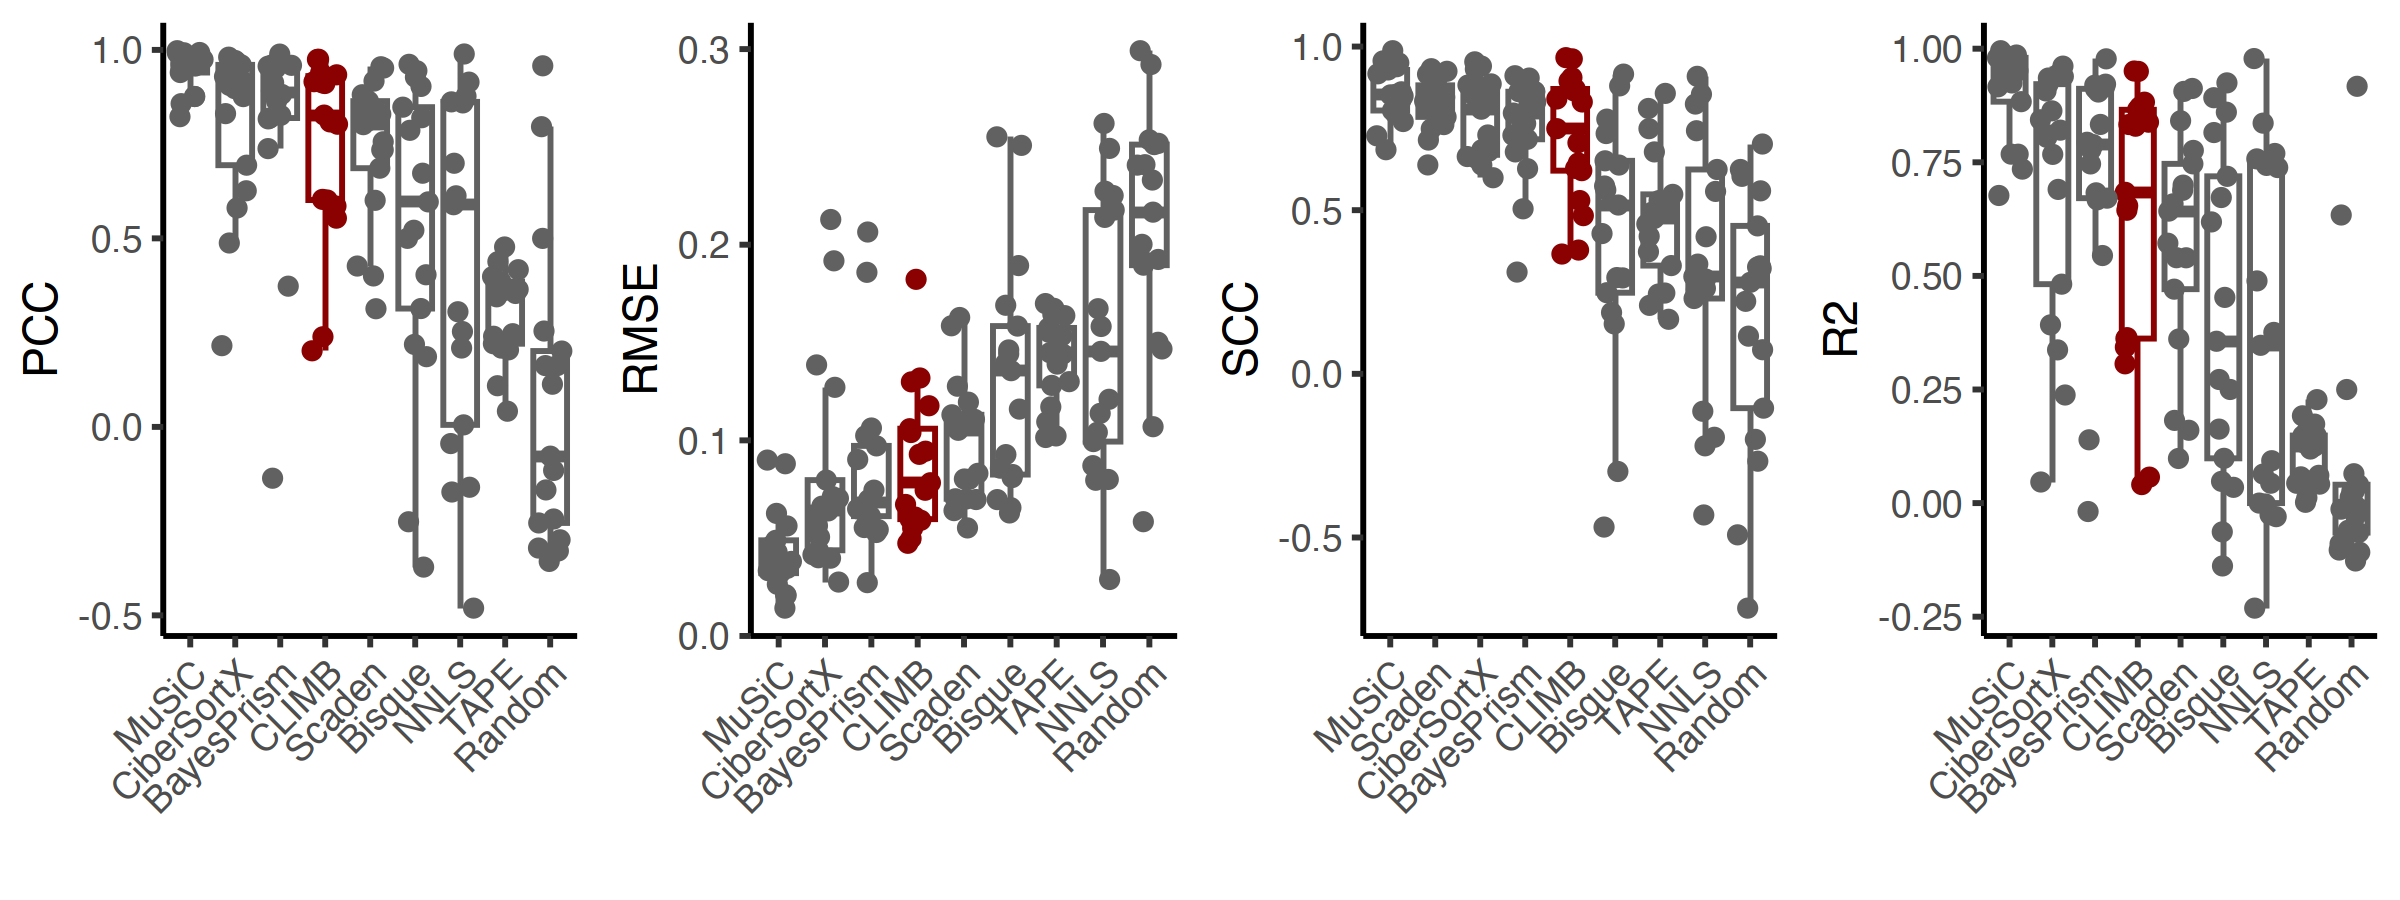

In [431]:
options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
pdf('results/fig3/boxplot_psample_4metrics_tir2jer.pdf', width=8, height=3) ; g ; dev.off()
g

In [432]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(mel.jer2tir, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(mel.jer2tir, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(mel.jer2tir, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(mel.jer2tir, type.err='RMSE_per_sample') # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

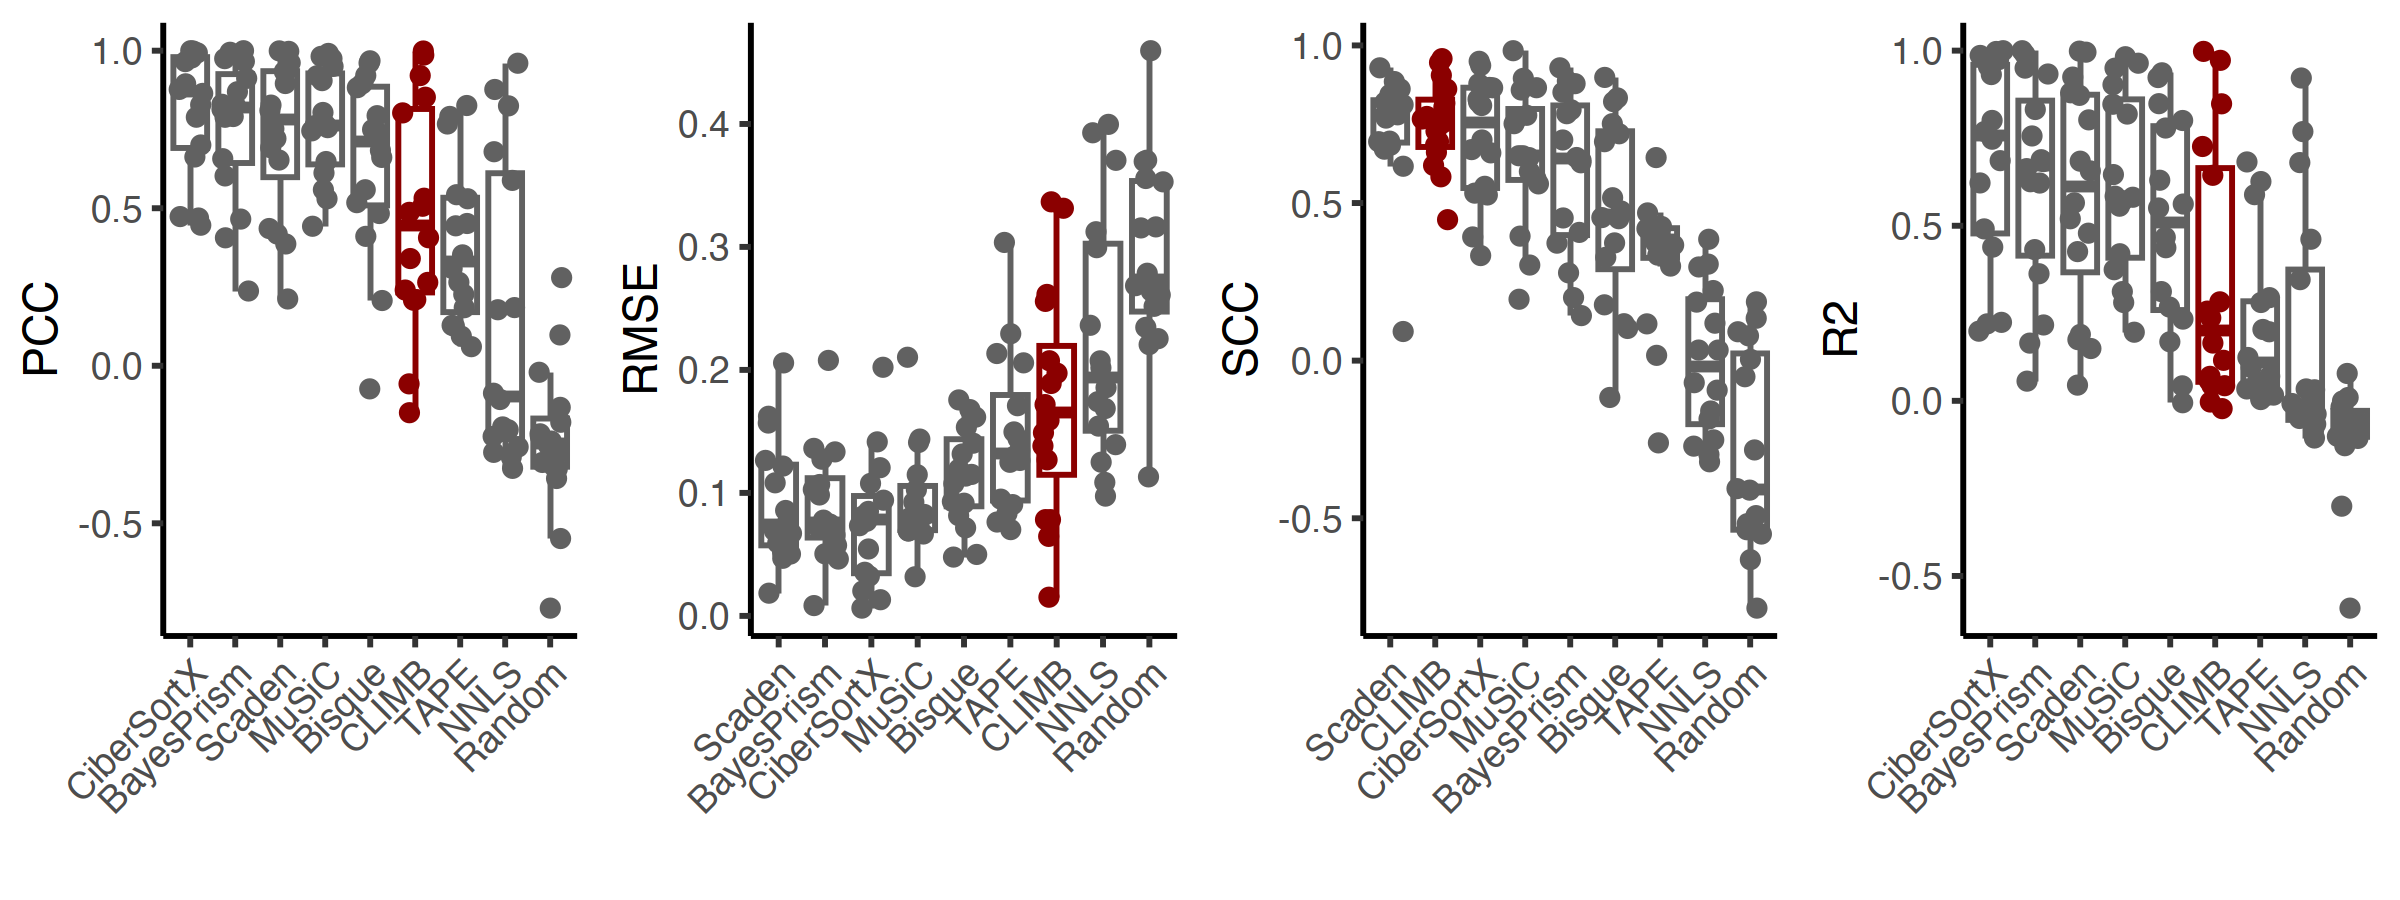

In [433]:
options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
pdf('results/fig3/boxplot_psample_4metrics_jer2tir.pdf', width=8, height=3) ; g ; dev.off()
g

pdf 
  2

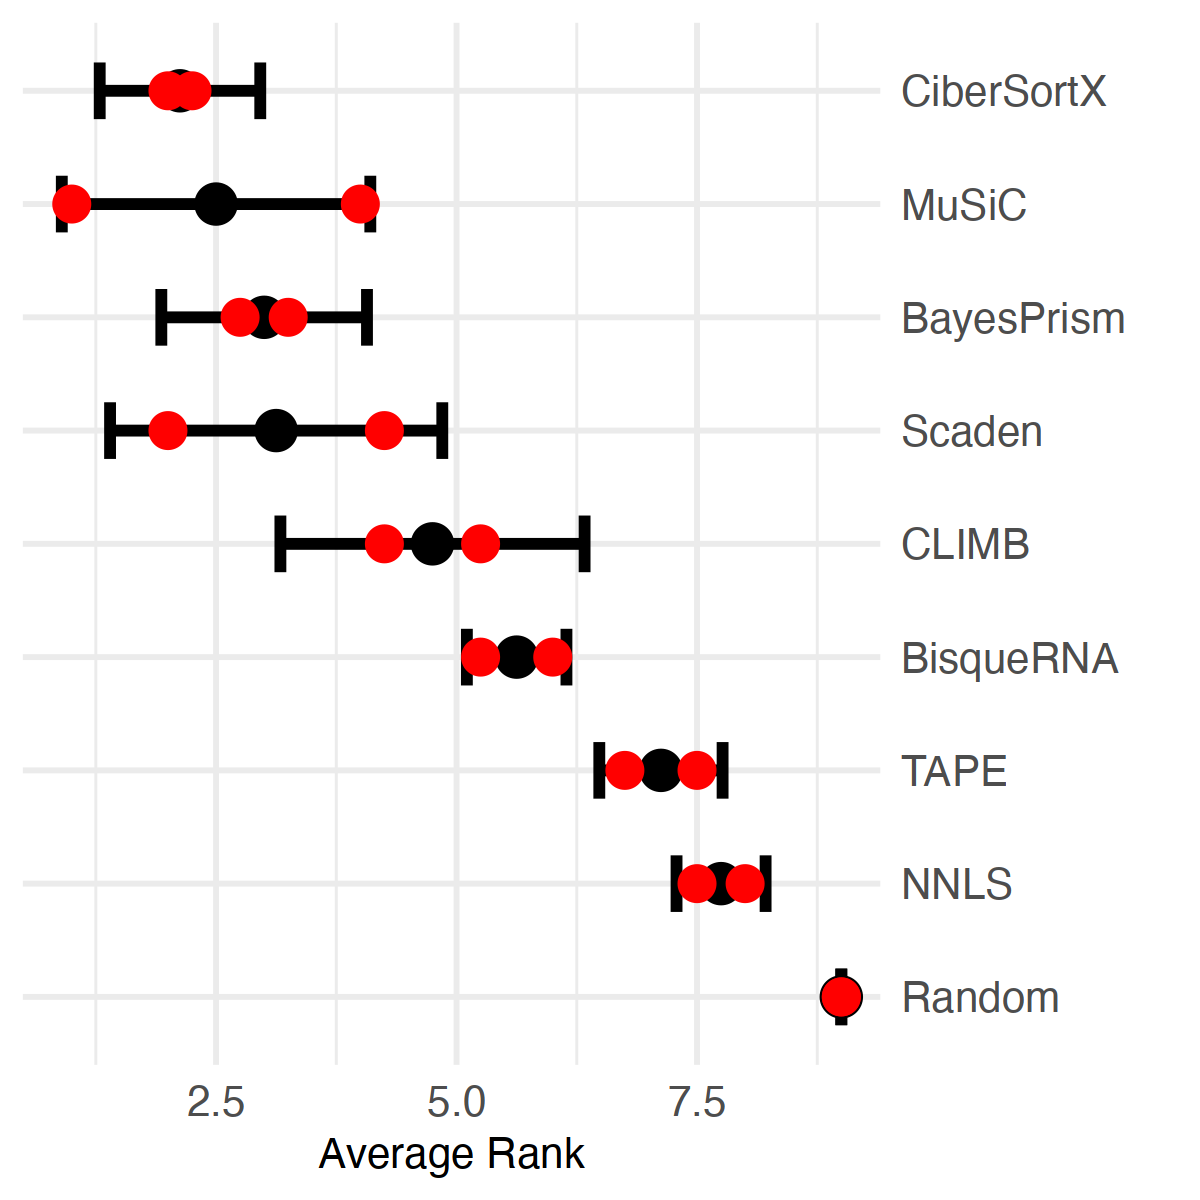

In [434]:
df_all.mel = cbind(ranks.jer2tir, ranks.tir2jer)
mat_ranks = as.matrix(df_all.mel)
df_all.mel$mean_overall = rowMeans(mat_ranks)
df_all.mel$std_overall = rowSds(mat_ranks)
df_all.mel$mean_inter1 = rowMeans(as.matrix(ranks.jer2tir))
df_all.mel$mean_inter2 = rowMeans(as.matrix(ranks.tir2jer))
df_all.mel$method = rownames(df_all.mel)
df_all.mel$method = factor(df_all.mel$method, levels=rev(df_all.mel$method[order(df_all.mel$mean_overall)]))
df_all.mel = df_all.mel[,(dim(df_all.mel)[2]-10):dim(df_all.mel)[2]]
options(repr.plot.width=4, repr.plot.height=4)
g <- ggplot() + geom_errorbar(data=df_all.mel, aes(y=method, xmin=mean_overall-std_overall, xmax=mean_overall+std_overall), width=0.5, size=1, color="black") +
    geom_point(data=df_all.mel, aes(x=mean_overall, y=method), size=4.0, color='black') + 
    geom_point(data=df_all.mel, aes(x=mean_inter1, y=method), size=3.5, color='red') +
    geom_point(data=df_all.mel, aes(x=mean_inter2, y=method), size=3.5, color='red') +
    theme_minimal() + theme(axis.text=element_text(size = 10), text=element_text(size = 10)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "right")
pdf('results/fig3/rank_dots_4metrics_MEL.pdf', width=3, height=3) ; g ; dev.off()
g

## Breast

In [435]:
out_dir = 'data/pseudobulks_climb/BREAST_gray2wu/'
breast.gray2wu = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
out_dir = 'data/pseudobulks_climb/BREAST_wu2gray/'
breast.wu2gray = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
ranks.gray2wu = rank_all_metrics(breast.gray2wu)
ranks.wu2gray = rank_all_metrics(breast.wu2gray)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [436]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(breast.gray2wu, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(breast.gray2wu, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(breast.gray2wu, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(breast.gray2wu, type.err='RMSE_per_sample') # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

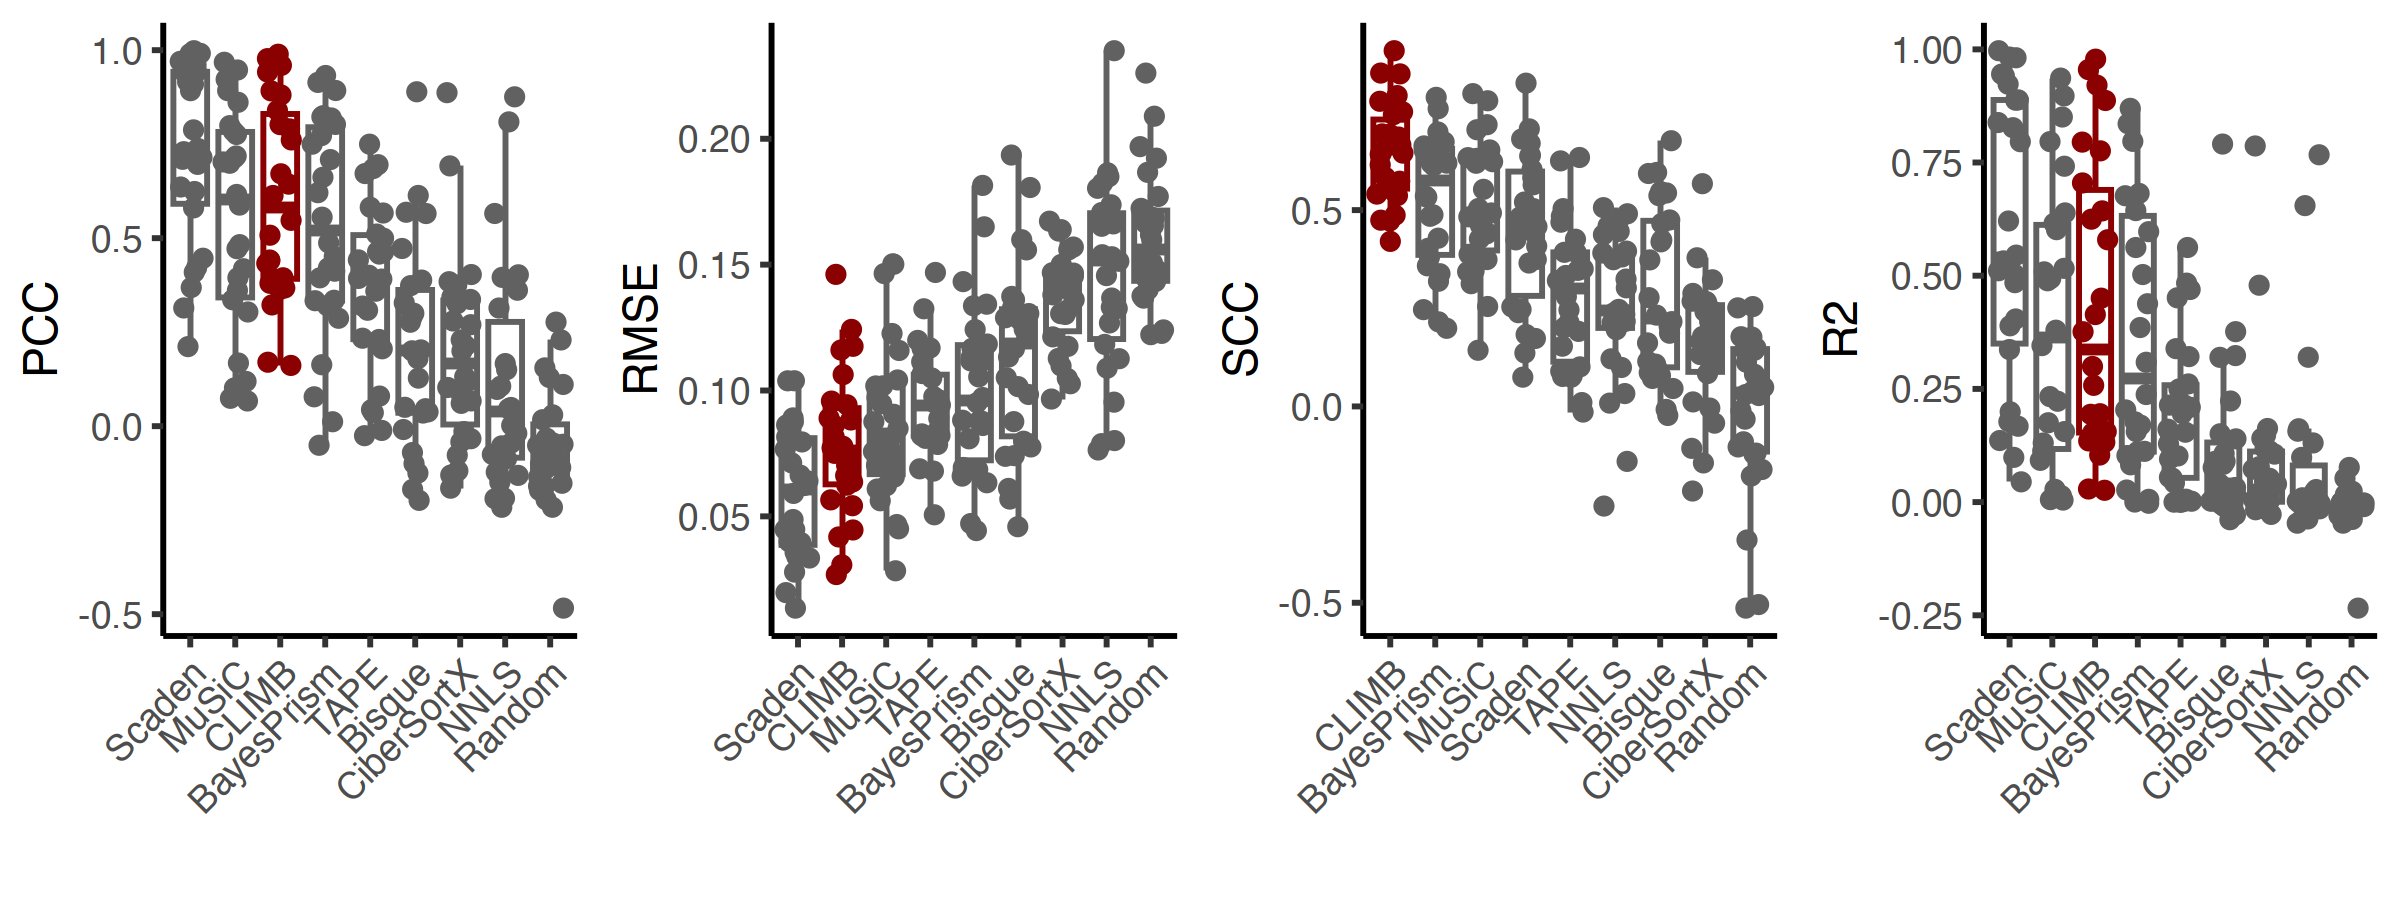

In [437]:
options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
pdf('results/fig3/boxplot_psample_4metrics_gray2wu.pdf', width=8, height=3) ; g ; dev.off()
g

In [438]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(breast.wu2gray, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(breast.wu2gray, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(breast.wu2gray, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(breast.wu2gray, type.err='RMSE_per_sample') # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

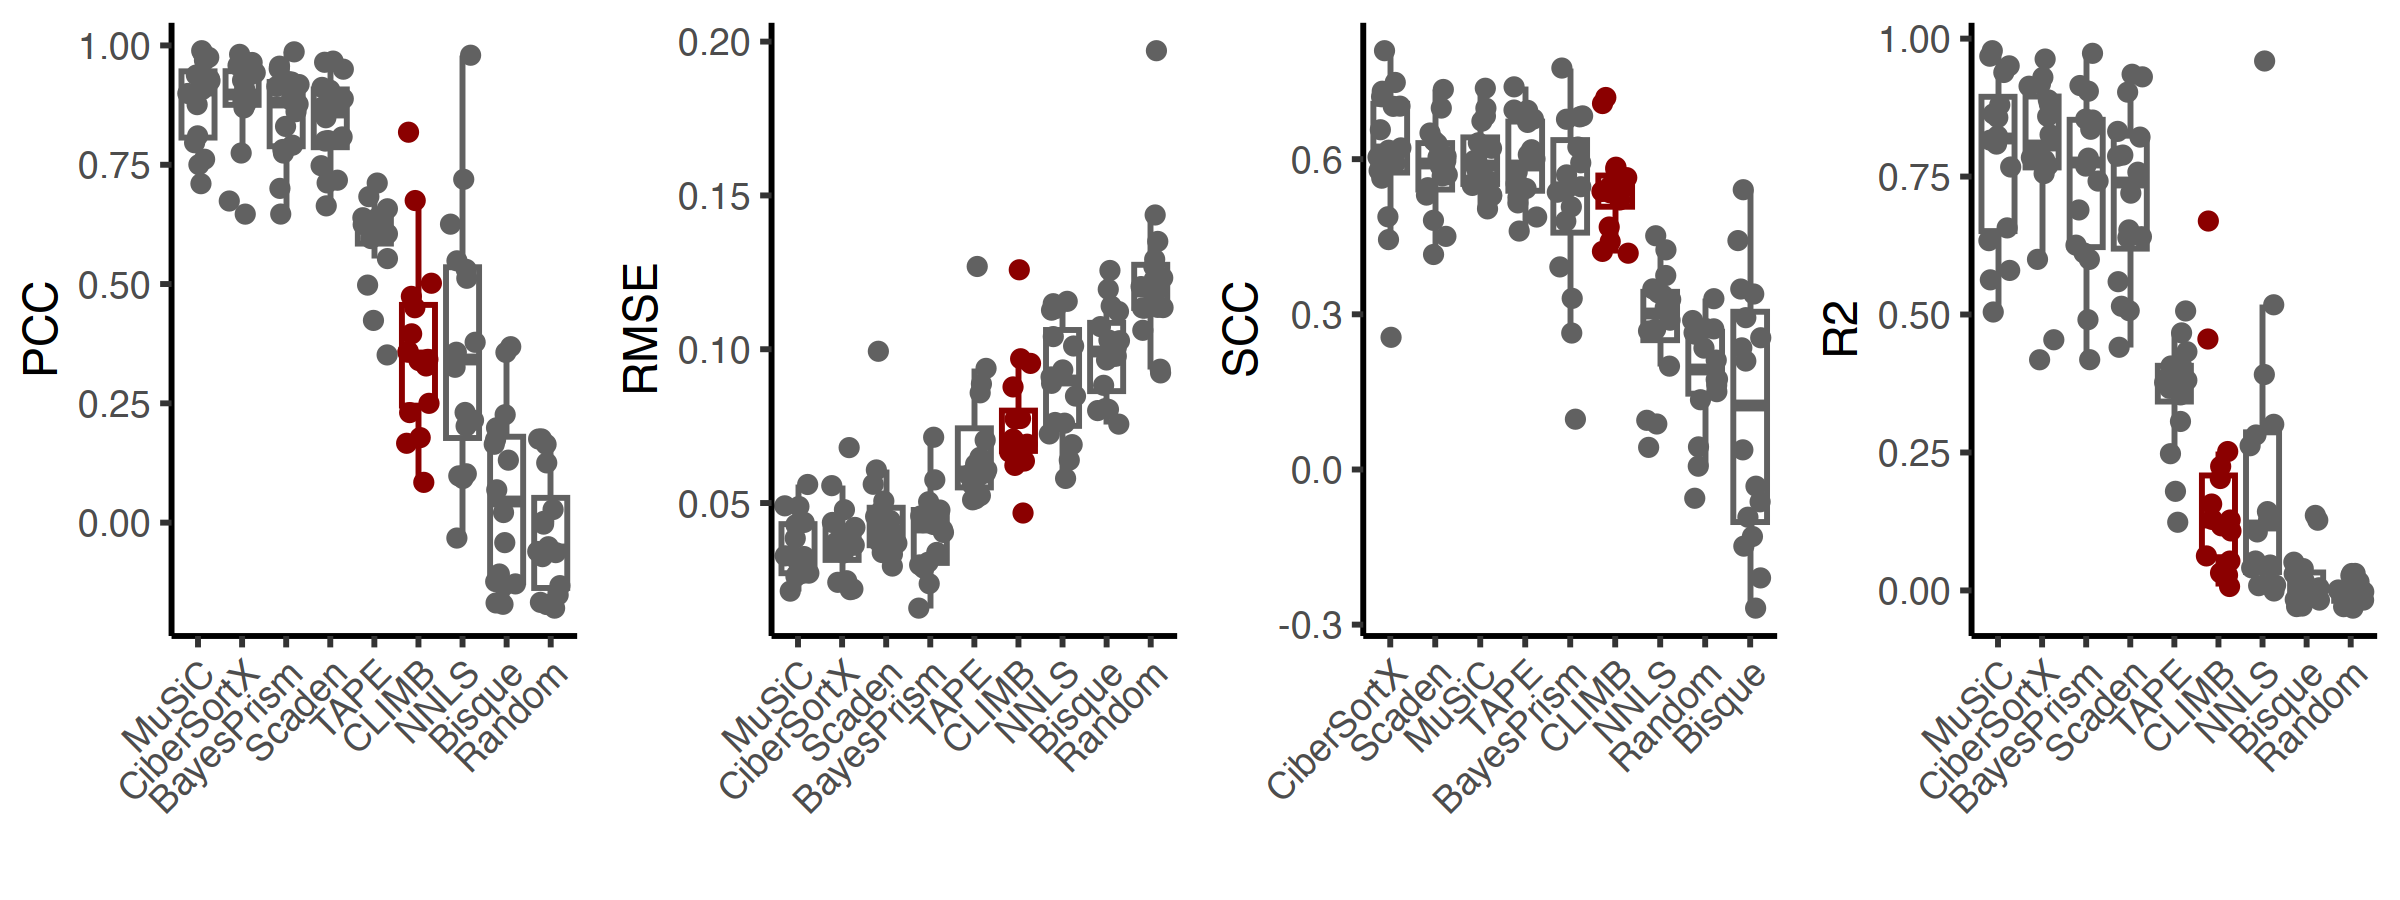

In [439]:
options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
pdf('results/fig3/boxplot_psample_4metrics_wu2gray.pdf', width=8, height=3) ; g ; dev.off()
g

pdf 
  2

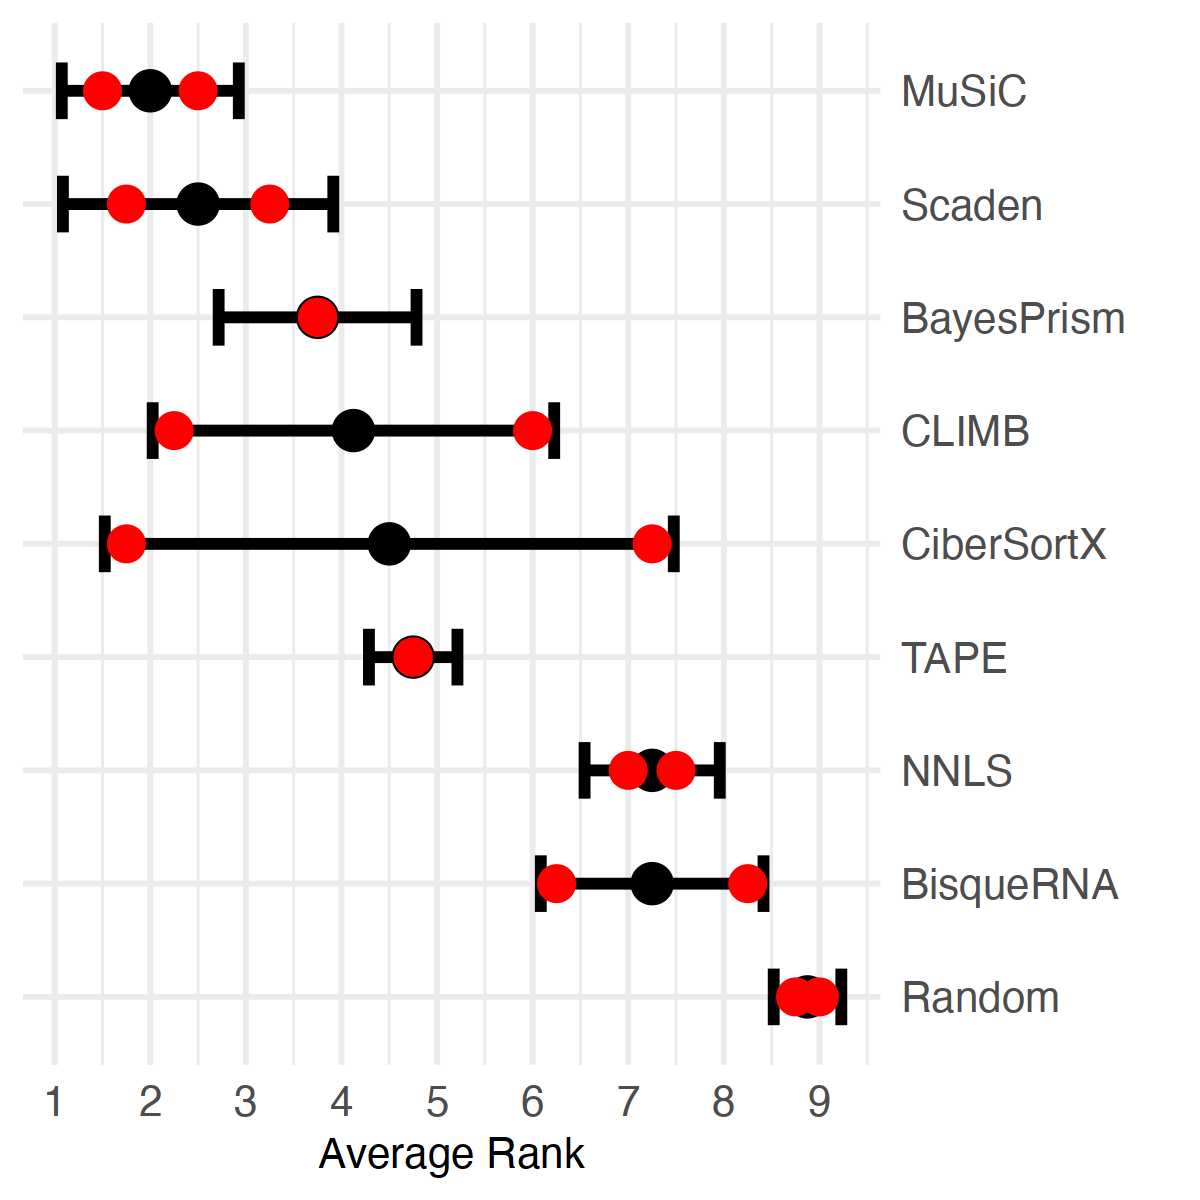

In [440]:
df_all.mel = cbind(ranks.gray2wu, ranks.wu2gray)
mat_ranks = as.matrix(df_all.mel)
df_all.mel$mean_overall = rowMeans(mat_ranks)
df_all.mel$std_overall = rowSds(mat_ranks)
df_all.mel$mean_inter1 = rowMeans(as.matrix(ranks.gray2wu))
df_all.mel$mean_inter2 = rowMeans(as.matrix(ranks.wu2gray))
df_all.mel$method = rownames(df_all.mel)
df_all.mel$method = factor(df_all.mel$method, levels=rev(df_all.mel$method[order(df_all.mel$mean_overall)]))
df_all.mel = df_all.mel[,(dim(df_all.mel)[2]-10):dim(df_all.mel)[2]]
options(repr.plot.width=4, repr.plot.height=4)
g <- ggplot() + geom_errorbar(data=df_all.mel, aes(y=method, xmin=mean_overall-std_overall, xmax=mean_overall+std_overall), width=0.5, size=1, color="black") +
    geom_point(data=df_all.mel, aes(x=mean_overall, y=method), size=4.0, color='black') + 
    geom_point(data=df_all.mel, aes(x=mean_inter1, y=method), size=3.5, color='red') +
    geom_point(data=df_all.mel, aes(x=mean_inter2, y=method), size=3.5, color='red') +
    scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 10), text=element_text(size = 10)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "right")
pdf('results/fig3/rank_dots_4metrics_BREAST.pdf', width=3, height=3) ; g ; dev.off()
g

## GBM

In [441]:
out_dir = 'data/pseudobulks_climb/GBM_SS2tenX'
gbm.ss2tenx = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
out_dir = 'data/pseudobulks_climb/GBM_10x2ss2'
gbm.tenx2ss = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
ranks.ss2tenx = rank_all_metrics(gbm.ss2tenx)
ranks.tenx2ss = rank_all_metrics(gbm.tenx2ss)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [442]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(gbm.tenx2ss, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(gbm.tenx2ss, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(gbm.tenx2ss, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(gbm.tenx2ss, type.err='RMSE_per_sample') # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

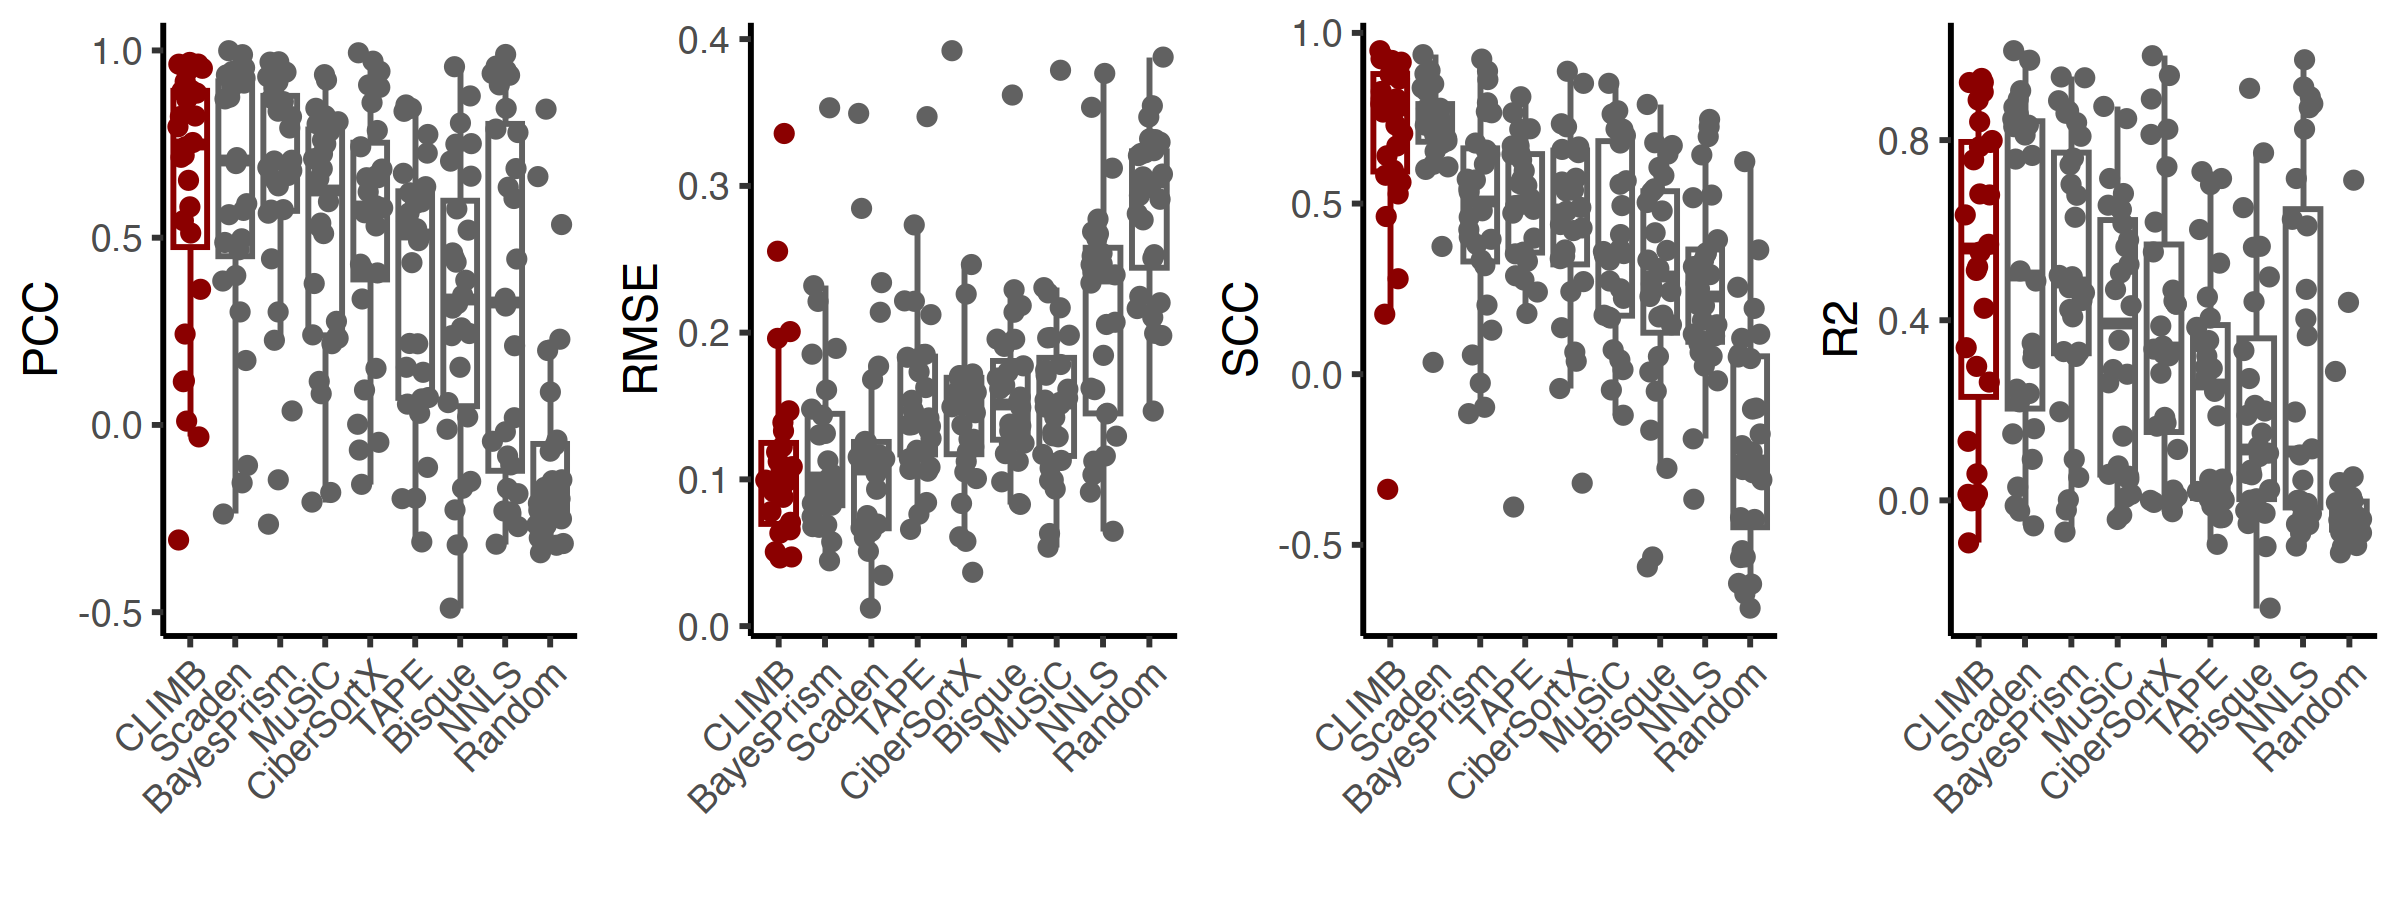

In [443]:
options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
pdf('results/fig3/boxplot_psample_4metrics_gbm_tenx2ss.pdf', width=8, height=3) ; g ; dev.off()
g

In [444]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse
g_pcc = generate_comp_plot(gbm.ss2tenx, type.err='PCC_per_sample') # PCC
g_scc = generate_comp_plot(gbm.ss2tenx, type.err='SCC_per_sample') # SCC
g_r2 = generate_comp_plot(gbm.ss2tenx, type.err='R2_per_sample') # R-square
g_rmse = generate_comp_plot(gbm.ss2tenx, type.err='RMSE_per_sample') # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

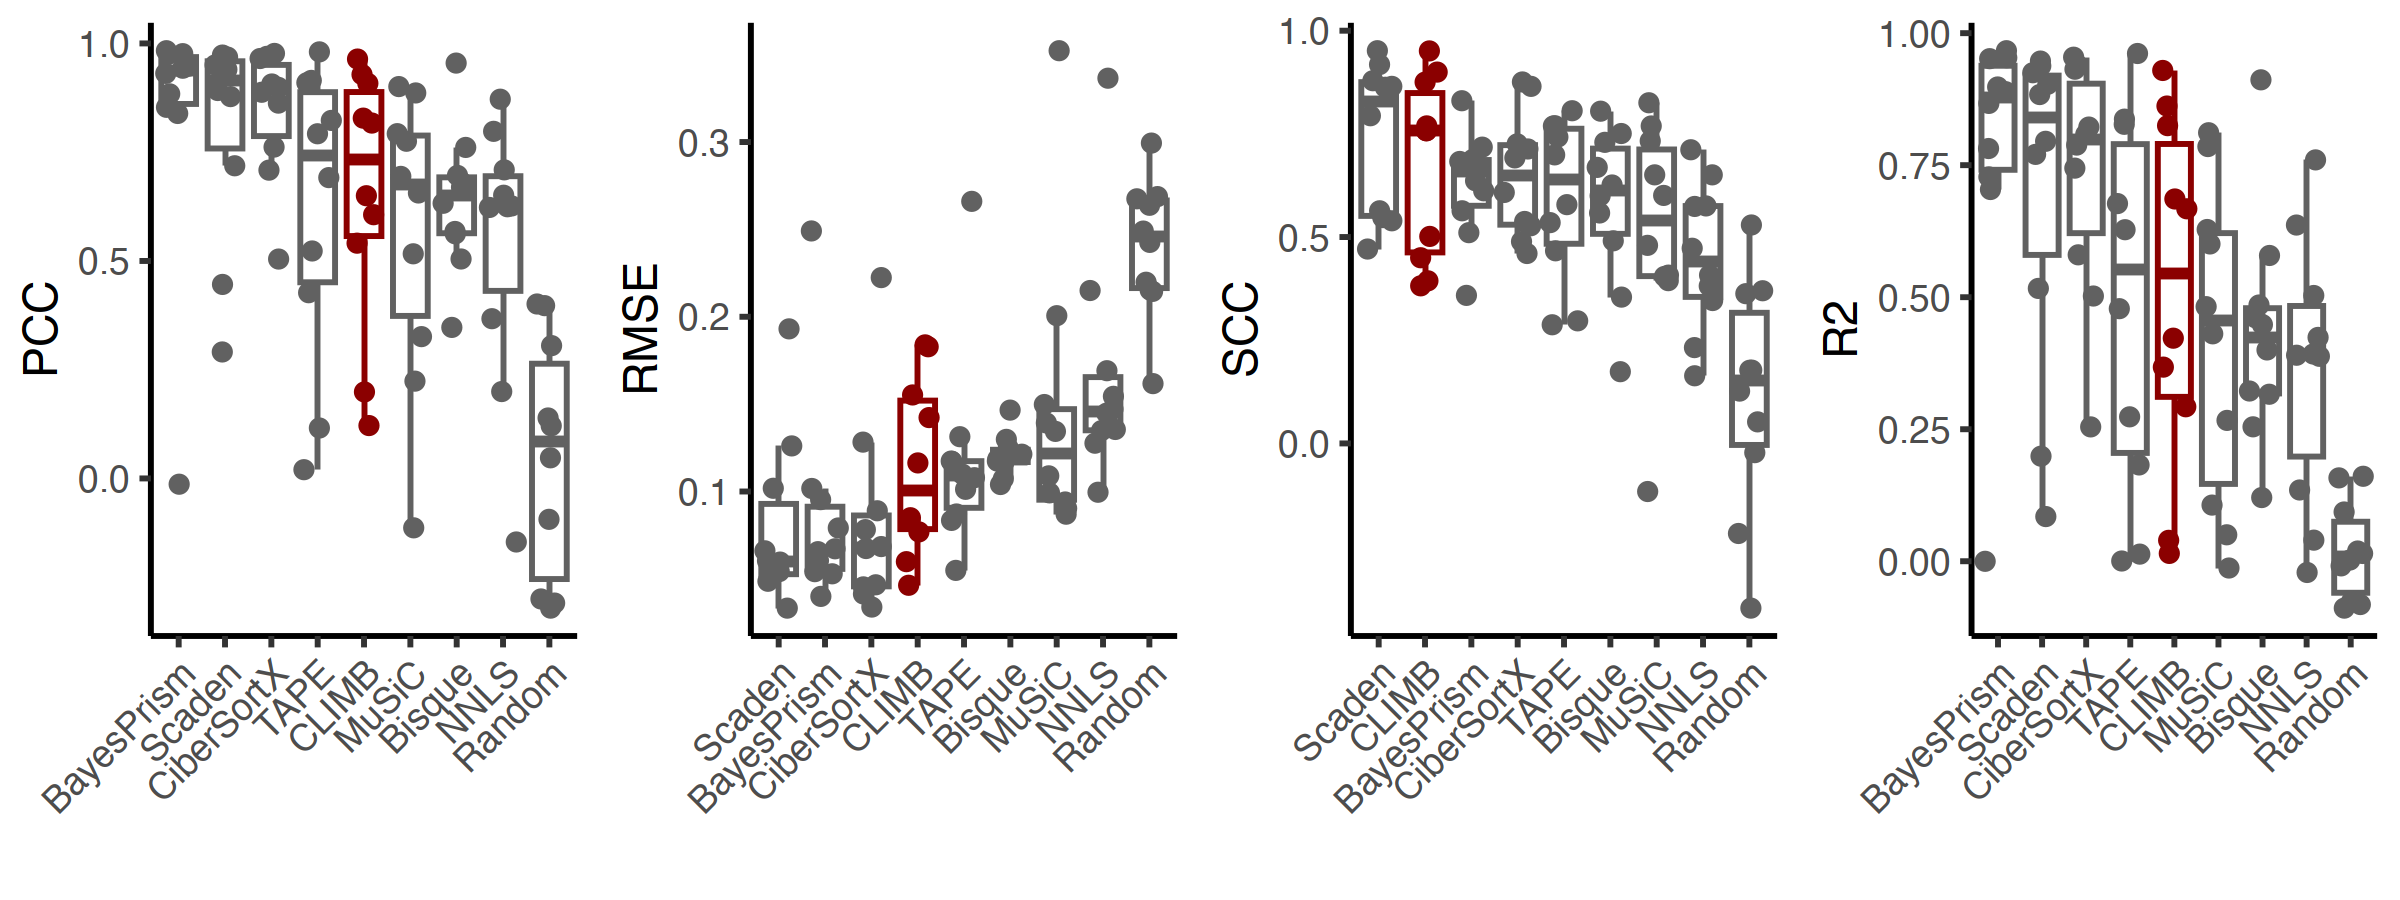

In [445]:
options(repr.plot.width=8, repr.plot.height=3)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
pdf('results/fig3/boxplot_psample_4metrics_gbm_ss2tenx.pdf', width=8, height=3) ; g ; dev.off()
g

pdf 
  2

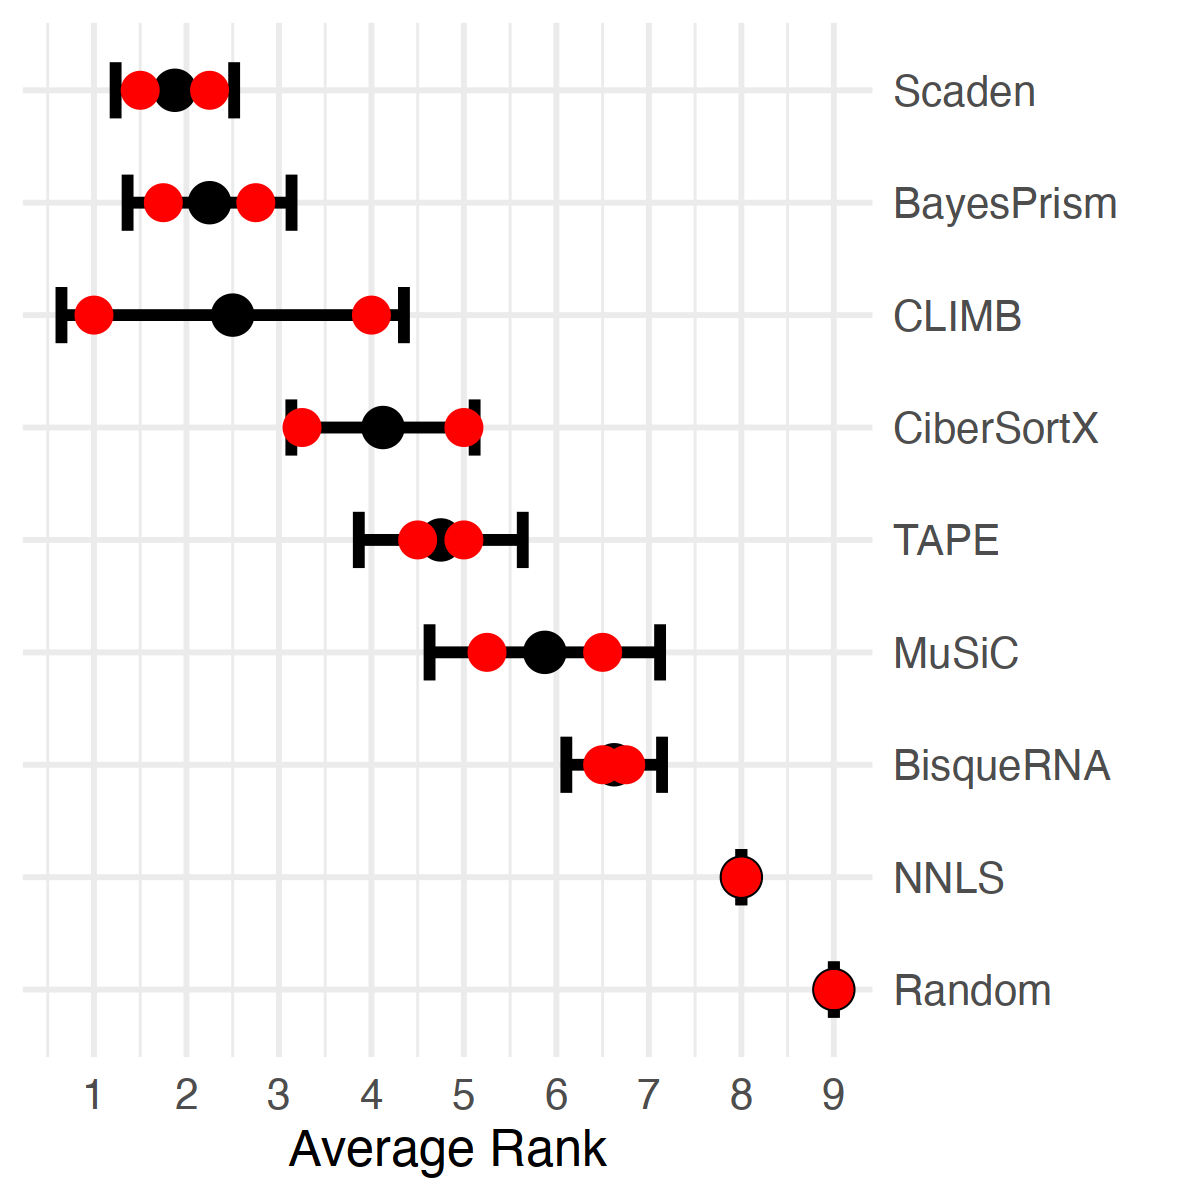

In [446]:
mat_ranks = as.matrix(cbind(ranks.ss2tenx, ranks.tenx2ss))
df_all.mel$mean_overall = rowMeans(mat_ranks)
df_all.mel$std_overall = rowSds(mat_ranks)
df_all.mel$mean_inter1 = rowMeans(as.matrix(ranks.ss2tenx))
df_all.mel$mean_inter2 = rowMeans(as.matrix(ranks.tenx2ss))
df_all.mel$method = rownames(df_all.mel)
df_all.mel$method = factor(df_all.mel$method, levels=rev(df_all.mel$method[order(df_all.mel$mean_overall)]))
df_all.mel = df_all.mel[,(dim(df_all.mel)[2]-10):dim(df_all.mel)[2]]
options(repr.plot.width=4, repr.plot.height=4)
g <- ggplot() + geom_errorbar(data=df_all.mel, aes(y=method, xmin=mean_overall-std_overall, xmax=mean_overall+std_overall), width=0.5, size=1, color="black") +
    geom_point(data=df_all.mel, aes(x=mean_overall, y=method), size=4.0, color='black') + 
    geom_point(data=df_all.mel, aes(x=mean_inter1, y=method), size=3.5, color='red') +
    geom_point(data=df_all.mel, aes(x=mean_inter2, y=method), size=3.5, color='red') +
    scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 10), text=element_text(size = 12)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "right")
pdf('results/fig3/rank_dots_4metrics_GBM.pdf', width=3, height=3) ; g ; dev.off()
g

# Assemble all analysis in one figure and statistic

In [377]:
mat_ranks = as.matrix(cbind(ranks.vg2na, ranks.na2vg, ranks.vg2na_200sim, ranks.invitro, # AML comparison
                     ranks.kha2lee, ranks.lee2kha, # CRC comparison
                     ranks.jer2tir, ranks.tir2jer, # MEL comparison
                     ranks.gray2wu, ranks.wu2gray, # BREAST comparison
                     ranks.ss2tenx, ranks.tenx2ss)) # GBM comparison

In [378]:
df_all.merge = data.frame(mean_overall = rowMeans(mat_ranks))
df_all.merge$std_overall = rowSds(mat_ranks)
df_all.merge$vg2na = rowMeans(as.matrix(ranks.vg2na))
df_all.merge$na2vg = rowMeans(as.matrix(ranks.na2vg))
df_all.merge$na2vg_200sim = rowMeans(as.matrix(ranks.vg2na_200sim))
df_all.merge$invitro = rowMeans(as.matrix(ranks.invitro))
df_all.merge$kha2lee = rowMeans(as.matrix(ranks.kha2lee))
df_all.merge$lee2kha = rowMeans(as.matrix(ranks.lee2kha))
df_all.merge$jer2tir = rowMeans(as.matrix(ranks.jer2tir))
df_all.merge$tir2jer = rowMeans(as.matrix(ranks.tir2jer))
df_all.merge$gray2wu = rowMeans(as.matrix(ranks.gray2wu))
df_all.merge$wu2gray = rowMeans(as.matrix(ranks.wu2gray))
df_all.merge$ss2tenx = rowMeans(as.matrix(ranks.ss2tenx))
df_all.merge$tenx2ss = rowMeans(as.matrix(ranks.tenx2ss))

df_all.merge$method = rownames(df_all.merge)
df_all.merge$method = factor(df_all.merge$method, levels=rev(df_all.merge$method[order(df_all.merge$mean_overall)][c(2,1,3:9)]))

pdf 
  2

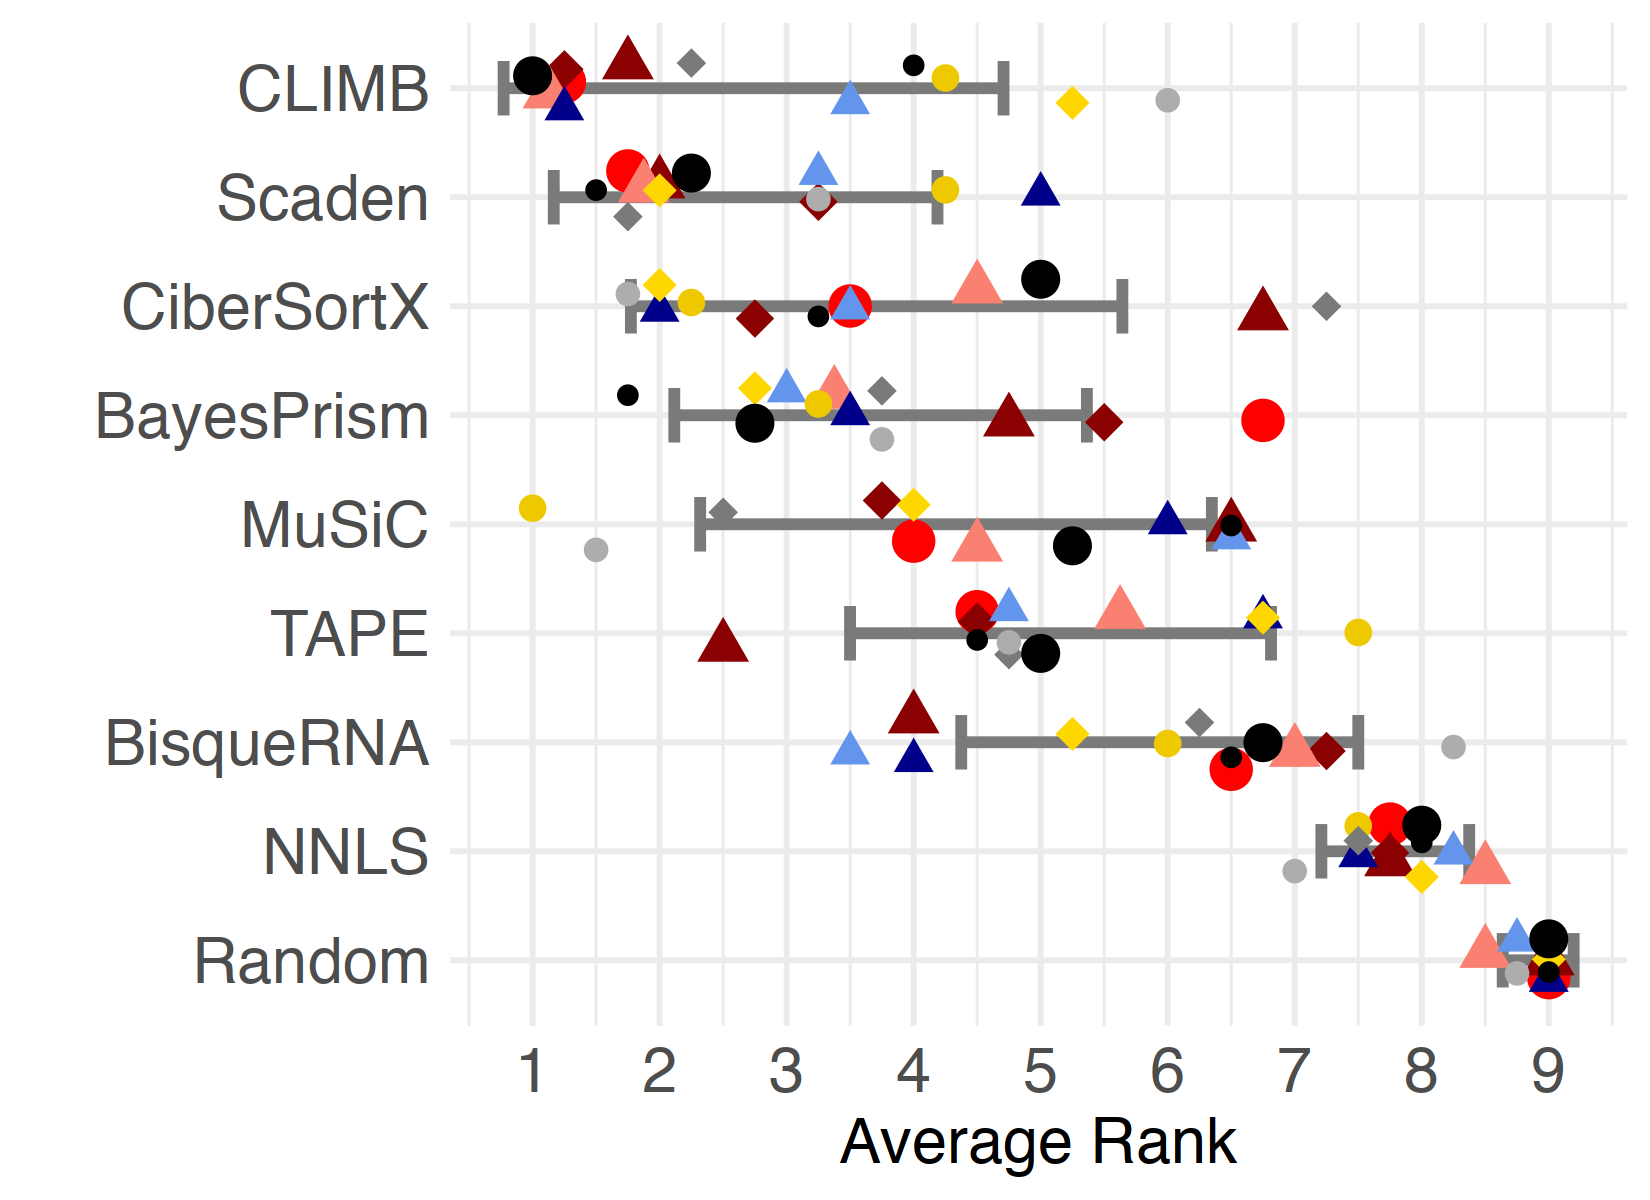

In [381]:
options(repr.plot.width=5.5, repr.plot.height=4)
g <- ggplot(data=df_all.merge) + 
    geom_errorbar(aes(y=method, xmin=mean_overall-std_overall, xmax=mean_overall+std_overall), width=0.5, size=1, color="grey48") +
    #geom_point(aes(x=mean_overall, y=method), size=5.0, color='grey28') + 
    geom_point(aes(x=vg2na, y=method), position = position_jitter(w = 0, h = 0.25), size=4, color='red') + 
    geom_point(aes(x=na2vg, y=method), position = position_jitter(w = 0, h = 0.25), size=4, color='darkred', shape=17)+
    geom_point(aes(x=na2vg_200sim, y=method), position = position_jitter(w = 0, h = 0.25), size=4, color='darkred', shape=18)+
    geom_point(aes(x=invitro, y=method), position = position_jitter(w = 0, h = 0.25), size=4, color='salmon', shape=17)+
    geom_point(aes(x=kha2lee, y=method), position = position_jitter(w = 0, h = 0.25), size=3, color='cornflowerblue', shape=17)+
    geom_point(aes(x=lee2kha, y=method), position = position_jitter(w = 0, h = 0.25), size=3, color='darkblue', shape=17)+
    geom_point(aes(x=jer2tir, y=method), position = position_jitter(w = 0, h = 0.25), size=3.5, color='gold1', shape=18)+
    geom_point(aes(x=tir2jer, y=method), position = position_jitter(w = 0, h = 0.25), size=3.5, color='gold2', shape=20)+
    geom_point(aes(x=gray2wu, y=method), position = position_jitter(w = 0, h = 0.25), size=3, color='grey48', shape=18)+
    geom_point(aes(x=wu2gray, y=method), position = position_jitter(w = 0, h = 0.25), size=3, color='grey68', shape=20)+
    geom_point(aes(x=ss2tenx, y=method), position = position_jitter(w = 0, h = 0.25), size=2.5, color='black', shape=20)+
    geom_point(aes(x=tenx2ss, y=method), position = position_jitter(w = 0, h = 0.25), size=3.5, color='black', shape=19)+
    scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 15), text=element_text(size = 15)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "left")
pdf('results/fig3/rank_dots_ALL_cross_analysis.pdf', width=6.5, height=4.5) ; g ; dev.off()
g

In [380]:
rownames(mat_ranks)[2]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[2,]))$p.value)
rownames(mat_ranks)[3]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[3,]))$p.value)
rownames(mat_ranks)[4]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[4,]))$p.value)
rownames(mat_ranks)[5]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[5,]))$p.value)
rownames(mat_ranks)[6]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[6,]))$p.value)
rownames(mat_ranks)[7]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[7,]))$p.value)
rownames(mat_ranks)[8]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[8,]))$p.value)

[1] "Scaden"

[1] 0.4398189

[1] "TAPE"

[1] 1.770012e-07

[1] "CiberSortX"

[1] 0.006125489

[1] "BayesPrism"

[1] 0.004609769

[1] "MuSiC"

[1] 0.0003122351

[1] "NNLS"

[1] 7.699036e-18

[1] "BisqueRNA"

[1] 5.218892e-11

## Comparison of CLIMB and CLIMB-DW

In [487]:
climb_comp_pcc = data.frame(rbind(cbind(aml.na2vg$`CLIMB-DW`[[1]], rep('CLIMB-DW', length(aml.na2vg$`CLIMB-DW`[[1]])), rep('inter', length(aml.na2vg$`CLIMB-DW`[[1]])), rep('na2vg', length(aml.na2vg$`CLIMB-DW`[[1]]))),
      cbind(aml.vg2na$`CLIMB-DW`[[1]], rep('CLIMB-DW', length(aml.vg2na$`CLIMB-DW`[[1]])), rep('inter', length(aml.vg2na$`CLIMB-DW`[[1]])), rep('vg2na', length(aml.vg2na$`CLIMB-DW`[[1]]))),
      cbind(aml.na2vg$CLIMB[[1]], rep('CLIMB', length(aml.na2vg$CLIMB[[1]])), rep('inter', length(aml.na2vg$CLIMB[[1]])), rep('na2vg', length(aml.na2vg$CLIMB[[1]]))),
      cbind(aml.vg2na$CLIMB[[1]], rep('CLIMB', length(aml.vg2na$CLIMB[[1]])), rep('inter', length(aml.vg2na$CLIMB[[1]])), rep('vg2na', length(aml.vg2na$CLIMB[[1]])))
                                 ))
colnames(climb_comp_pcc) <- c('PCC', 'method', 'comparison', 'dataset')

In [488]:
wilcox.test(num(climb_comp_pcc[climb_comp_pcc$method == 'CLIMB-DW',]$PCC),
            num(climb_comp_pcc[climb_comp_pcc$method == 'CLIMB',]$PCC))


	Wilcoxon rank sum exact test

data:  num(climb_comp_pcc[climb_comp_pcc$method == "CLIMB-DW", ]$PCC) and num(climb_comp_pcc[climb_comp_pcc$method == "CLIMB", ]$PCC)
W = 605, p-value = 0.003689
alternative hypothesis: true location shift is not equal to 0


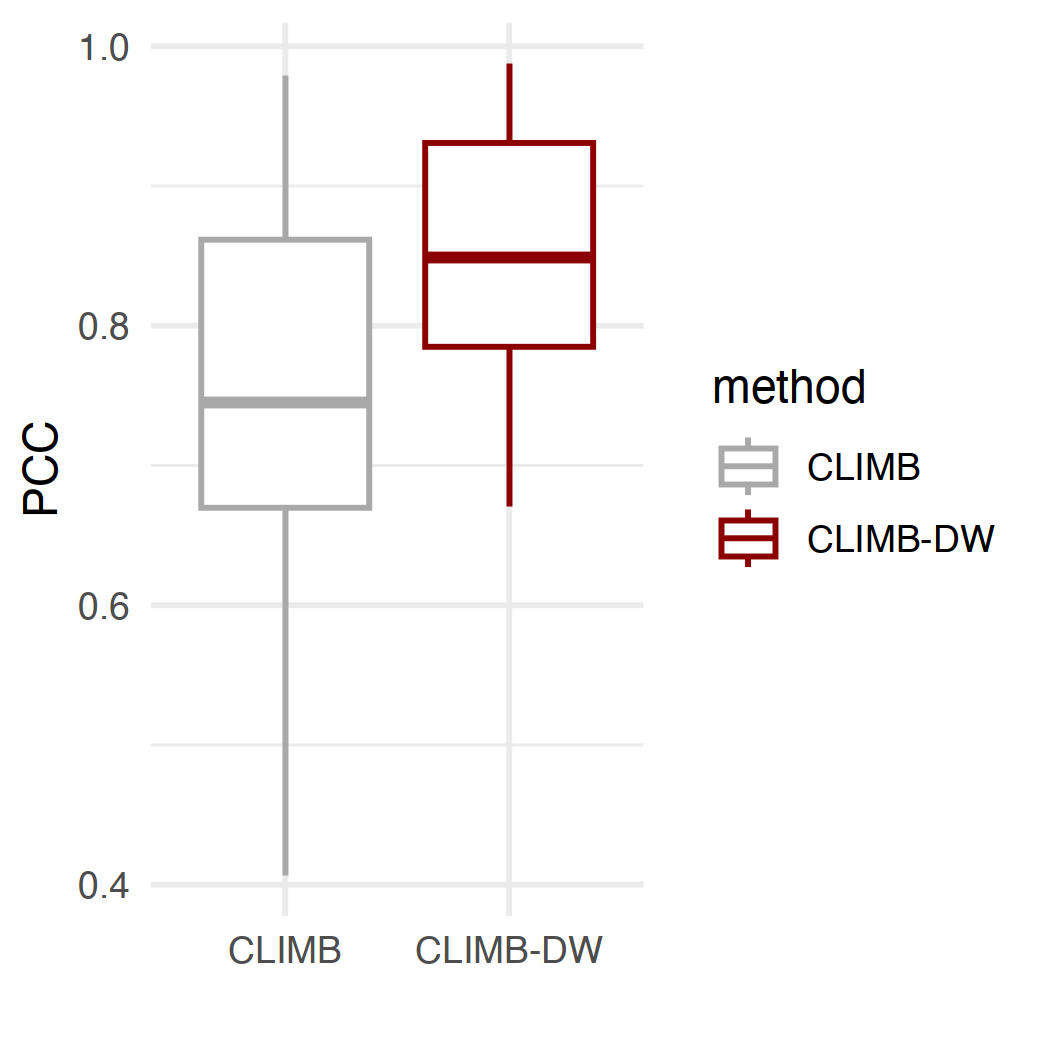

In [490]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
g <- ggplot(climb_comp_pcc) + geom_boxplot(aes(x=method, y=num(PCC), color=method)) + 
    theme_minimal() + scale_color_manual(values = rev(c('darkred', 'darkgrey'))) +
    xlab('') + ylab('PCC')
#pdf('results/pseudobulk_analysis/cross_datasets/figs/climb_vs_climbDW_AML.pdf', width=3.5, height=3.5) ; g ; dev.off()
g